# Particle Classification: Ablation Analysis

## Ablation Configurations

1. **Image-only**: CNN processing particle images only
2. **Features-only**: Dense network processing environmental features only
3. **Hybrid**: Combined image and environmental features (full model)

## Classes

- **Class 0**: Liquid water droplets
- **Class 1**: Solid ice crystals

## 1. Setup and Imports

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import pickle
import random
from pathlib import Path
from typing import Tuple, Dict, List

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    cohen_kappa_score,
    f1_score,
    precision_score,
    recall_score
)


# Statistical testing
from scipy.stats import ttest_rel, wilcoxon

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Concatenate, BatchNormalization, SpatialDropout2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Progress bar
from tqdm import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
GPU available: True


## 2. Reproducibility: Seed Control

**Critical for ablation studies**: We must control ALL sources of randomness to ensure fair comparisons.

In [ ]:
def set_all_seeds(seed: int = 42):
    """
    Set seeds for reproducibility across all libraries.

    This MUST be called at the start of each experiment run to ensure:
    - Identical weight initialization
    - Identical data shuffling
    - Identical dropout masks
    - Identical augmentation randomness

    Parameters:
    -----------
    seed : int
        Random seed value
    """
    # Python random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # TensorFlow
    tf.random.set_seed(seed)

    # For TensorFlow determinism (slower but more reproducible)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # For Python hash randomization
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"✓ All random seeds set to {seed}")


# Set initial seed for data preparation
set_all_seeds(42)

✓ All random seeds set to 42


## 3. Google Drive Setup (for Colab)

In [ ]:
# Uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/GEOG5100/aircraft_ml/'

# # For local execution
# base_path = '/Users/srunkel/dev/aircraft_ML/'

# print(f"Base path: {base_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4. Load and Prepare Data

In [ ]:
# Load particle data
df = pd.read_csv(os.path.join(base_path, 'particle_df.csv'))

print(f"Total particles: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['phase'].value_counts().sort_index())
print(f"\nFirst few rows:")
df.head()

Total particles: 7182

Columns: ['particle_idx_seq', 'Time', 'phase', 'aircrafttas', 'xsize', 'ysize', 'area', 'diam', 'aspectratio', 'arearatio', 'QCTF', 'GGTRK', 'VSPD_IRS3']

Class distribution:
phase
0    2302
1    1950
2    2230
3     700
Name: count, dtype: int64

First few rows:


,particle_idx_seq,Time,phase,aircrafttas,xsize,ysize,area,diam,aspectratio,arearatio,QCTF,GGTRK,VSPD_IRS3
0,0,2025-05-24 02:28:03,3,0.0,40.0,120.0,20,124.01754,0.363516,0.165567,-0.3962,254.25682,0.001651
1,1,2025-05-24 02:32:55,3,0.0,20.0,70.0,9,70.82763,0.303666,0.228427,-0.4020,234.99437,-0.000546
2,2,2025-05-24 02:38:27,3,0.0,20.0,70.0,10,70.82763,0.326877,0.253808,-0.4000,255.11711,-0.014059
3,4641,2025-05-24 02:40:01,2,0.0,70.0,60.0,12,82.11102,0.797335,0.226615,-0.3352,359.53357,-0.001486
4,4643,2025-05-24 02:40:57,0,0.0,160.0,130.0,123,162.14363,0.799665,0.604993,-0.2416,297.48780,-0.045479


In [ ]:
# Filter for binary classification: Liquid (0) vs Solid (1)
# Remove donut (2) and noise (3) for this ablation study
df_filtered = df[df['phase'].isin([0, 1])].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"\nFiltered to binary classification:")
print(f"Total samples: {len(df_filtered)}")
print(f"\nClass distribution:")
print(df_filtered['phase'].value_counts().sort_index())
print(f"\nClass 0 (Liquid): {np.sum(df_filtered['phase'] == 0)} ({np.sum(df_filtered['phase'] == 0) / len(df_filtered) * 100:.1f}%)")
print(f"Class 1 (Solid): {np.sum(df_filtered['phase'] == 1)} ({np.sum(df_filtered['phase'] == 1) / len(df_filtered) * 100:.1f}%)")


Filtered to binary classification:
Total samples: 4252

Class distribution:
phase
0    2302
1    1950
Name: count, dtype: int64

Class 0 (Liquid): 2302 (54.1%)
Class 1 (Solid): 1950 (45.9%)


## 5. Create Image Paths and Extract Features

In [ ]:
# Create image file paths and FILTER out missing images
feature_columns = ['arearatio','aspectratio']

def get_image_path(row, base_path):
    """Get full path to particle image based on phase."""
    particle_num = row['particle_idx_seq']
    phase = row['phase']

    # Map phase to directory
    phase_dirs = {0: 'liquid', 1: 'solid'}
    subdir = phase_dirs[phase]

    return os.path.join(base_path, f'particle_images_filtered/{subdir}/particle_{particle_num}.png')

print("Creating image paths and checking existence...")

# Create paths
image_paths_temp = df_filtered.apply(lambda row: get_image_path(row, base_path), axis=1).values

# Check which images exist
print(f"Checking {len(image_paths_temp)} image paths...")
valid_indices = []
missing_count = 0

for idx, path in enumerate(image_paths_temp):
    if os.path.exists(path):
        valid_indices.append(idx)
    else:
        missing_count += 1

print(f"✓ Found {len(valid_indices)} images")
print(f"✗ Missing {missing_count} images")

# Filter to only include particles with existing images
df_filtered_with_images = df_filtered.iloc[valid_indices].reset_index(drop=True)
image_paths = image_paths_temp[valid_indices]

print(f"After filtering:  {len(df_filtered_with_images)} particles with images")
print(f"Class distribution after filtering:")
print(df_filtered_with_images['phase'].value_counts().sort_index())

# Extract environmental features (for particles with images only)
 # Air speed, Altitude, Diameter
for col in feature_columns:
  mean_value = df_filtered_with_images[col].mean()
  print(mean_value)
  df_filtered_with_images[col] = df_filtered_with_images[col].fillna(mean_value)
X_features = df_filtered_with_images[feature_columns].values
y_labels = df_filtered_with_images['phase'].values

# Handle NaN values in scaled features, replacing them with 0.0 (the mean of scaled features)


print(f"Feature matrix shape: {X_features.shape}")
print(f"Features: {feature_columns}")
print(f"Labels shape: {y_labels.shape}")
print(f"Feature statistics:")
print(pd.DataFrame(X_features, columns=feature_columns).describe())

Creating image paths and checking existence...
Checking 4252 image paths...
✓ Found 4222 images
✗ Missing 30 images
After filtering:  4222 particles with images
Class distribution after filtering:
phase
0    2283
1    1939
Name: count, dtype: int64
0.5191420888742302
0.60284187852937
Feature matrix shape: (4222, 2)
Features: ['arearatio', 'aspectratio']
Labels shape: (4222,)
Feature statistics:
         arearatio  aspectratio
count  4222.000000  4222.000000
mean      0.519142     0.602842
std       0.239827     0.223617
min       0.016417     0.051457
25%       0.300658     0.428781
50%       0.492587     0.628521
75%       0.759590     0.801862
max       0.969389     1.000000


## 6. Create and Save Data Splits

**Critical**: We create ONE set of data splits and save them to disk. All ablation experiments will use the SAME splits.

In [ ]:
# Set seed for splitting
set_all_seeds(16)

# Initial split: 90% temp, 10% test (stratified)
X_paths_temp, X_paths_test, \
X_features_temp, X_features_test, \
y_temp, y_test = train_test_split(
    image_paths,
    X_features,
    y_labels,
    test_size=0.15,
    stratify=y_labels,
    random_state=16
)

# Second split: 80% train, 10% validation (of temp)
# This gives us 80/10/10 split overall
X_paths_train, X_paths_val, \
X_features_train, X_features_val, \
y_train, y_val = train_test_split(
    X_paths_temp,
    X_features_temp,
    y_temp,
    test_size=0.175,  # 0.111 * 0.9 ≈ 0.1 of total
    stratify=y_temp,
    random_state=16
)

print(f"Training set: {len(X_paths_train)} samples ({len(X_paths_train)/len(image_paths)*100:.1f}%)")
print(f"Validation set: {len(X_paths_val)} samples ({len(X_paths_val)/len(image_paths)*100:.1f}%)")
print(f"Test set: {len(X_paths_test)} samples ({len(X_paths_test)/len(image_paths)*100:.1f}%)")

# Verify stratification
print(f"\nClass distribution in splits:")
print(f"Train - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
print(f"Val   - Class 0: {np.sum(y_val == 0)}, Class 1: {np.sum(y_val == 1)}")
print(f"Test  - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")

✓ All random seeds set to 16
Training set: 2960 samples (70.1%)
Validation set: 628 samples (14.9%)
Test set: 634 samples (15.0%)

Class distribution in splits:
Train - Class 0: 1600, Class 1: 1360
Val   - Class 0: 340, Class 1: 288
Test  - Class 0: 343, Class 1: 291


In [ ]:
# NOW fit scaler on training data only (prevent data leakage)
scaler = StandardScaler()
X_features_train_scaled = scaler.fit_transform(X_features_train)
X_features_val_scaled = scaler.transform(X_features_val)
X_features_test_scaled = scaler.transform(X_features_test)

print("✓ Features scaled using training data statistics only")
print(f"  Mean: {scaler.mean_}")
print(f"  Std: {scaler.scale_}")

✓ Features scaled using training data statistics only
  Mean: [0.51698879 0.60074093]
  Std: [0.23951564 0.22344015]


In [ ]:
# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"One-hot encoded labels:")
print(f"  Train: {y_train_cat.shape}")
print(f"  Val: {y_val_cat.shape}")
print(f"  Test: {y_test_cat.shape}")

One-hot encoded labels:
  Train: (2960, 2)
  Val: (628, 2)
  Test: (634, 2)


In [ ]:
# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass weights (to handle imbalance):")
for i, w in class_weight_dict.items():
    print(f"  Class {i}: {w:.3f}")


Class weights (to handle imbalance):
  Class 0: 0.925
  Class 1: 1.088


In [ ]:
# Save data splits to disk for reuse across ALL ablation experiments
def save_data_splits(save_dir='./data_splits_ablation'):
    """
    Save data splits to disk for reuse across ablation experiments.
    This ensures ALL models use IDENTICAL data splits.
    """
    os.makedirs(save_dir, exist_ok=True)

    splits = {
        'X_paths_train': X_paths_train,
        'X_paths_val': X_paths_val,
        'X_paths_test': X_paths_test,
        'X_features_train_scaled': X_features_train_scaled,
        'X_features_val_scaled': X_features_val_scaled,
        'X_features_test_scaled': X_features_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'y_train_cat': y_train_cat,
        'y_val_cat': y_val_cat,
        'y_test_cat': y_test_cat,
        'scaler': scaler,
        'class_weight_dict': class_weight_dict,
        'feature_columns': feature_columns
    }

    with open(os.path.join(save_dir, 'data_splits_seed42.pkl'), 'wb') as f:
        pickle.dump(splits, f)

    print(f"✓ Data splits saved to {save_dir}")
    return splits


def load_data_splits(save_dir='./data_splits_ablation'):
    """Load previously saved data splits."""
    with open(os.path.join(save_dir, 'data_splits_seed42.pkl'), 'rb') as f:
        splits = pickle.load(f)
    print("✓ Data splits loaded from disk")
    return splits


# Save the splits
data_splits = save_data_splits()

✓ Data splits saved to ./data_splits_ablation


## 7. Data Pipeline: tf.data.Dataset

Create efficient data loading pipelines with augmentation.

In [ ]:
# Configuration
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16
AUGMENTATION_PROB = 0.5

def random_geometric_augment(image: tf.Tensor) -> tf.Tensor:
    """Apply geometric augmentations suitable for particle images."""
    # Random 90-degree rotations
    if tf.random.uniform(()) < 0.5:
        k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)

    return image


def load_and_augment_hybrid(
    image_path: str,
    feature_vector: tf.Tensor,
    label: tf.Tensor,
    augment: bool
) -> Tuple[Tuple[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Load image, apply augmentation, and return (image, features) tuple with label.
    For hybrid model.
    """
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)

    # Apply augmentation if training
    if augment:
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = tf.image.flip_left_right(image)
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = tf.image.flip_up_down(image)
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = random_geometric_augment(image)

    # Normalize
    image = tf.clip_by_value(image, 0.0, 1.0)

    return (image, feature_vector), label


def load_and_augment_image_only(
    image_path: str,
    label: tf.Tensor,
    augment: bool
) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Load image and apply augmentation. For image-only model.
    """
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)

    # Apply augmentation if training
    if augment:
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = tf.image.flip_left_right(image)
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = tf.image.flip_up_down(image)
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            image = random_geometric_augment(image)

    # Normalize
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


print("✓ Data loading functions defined")

✓ Data loading functions defined


## 8. Model Architectures

**Critical**: All three configurations share the SAME classification head to ensure fair comparison.

In [ ]:
def build_cnn_branch(input_shape=(128, 128, 1), L2_REG=0.001):
    """
    Shared CNN architecture used across ALL ablation experiments.

    Architecture:
    - 4 Conv blocks (32→64→128→128 filters)
    - Batch normalization after each conv
    - MaxPooling 2x2
    - SpatialDropout2D for regularization
    - L2 regularization on conv layers

    Returns:
    --------
    image_input : Input layer
    cnn_features : Feature vector of size 128
    """
    image_input = Input(shape=input_shape, name='image_input')

    # Block 1: 32 filters
    x = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = SpatialDropout2D(0.2)(x)

    # Block 2: 64 filters
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = SpatialDropout2D(0.3)(x)

    # # Block 3: 128 filters
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = SpatialDropout2D(0.3)(x)

    # Flatten and dense
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    cnn_features = Dense(128, activation='relu',
                        kernel_regularizer=regularizers.l2(L2_REG),
                        name='cnn_features')(x)

    return image_input, cnn_features


def build_feature_branch(num_features=len(feature_columns), L2_REG=0.001):
    """
    Shared feature processing architecture.

    Returns:
    --------
    feature_input : Input layer
    feature_embedding : Feature vector of size 32
    """
    feature_input = Input(shape=(num_features,), name='feature_input')

    f = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG))(feature_input)
    f = Dropout(0.2)(f)
    f = Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG),
              name='feature_embeddin1')(f)
    f = Dropout(0.2)(f)
    f = Dense(32, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG),
              name='feature_embedding')(f)
    f = Dropout(0.2)(f)

    return feature_input, f


def build_classification_head(input_features, num_classes=2, L2_REG=0.001):
    """
    Shared classification head used across ALL models.

    This ensures fair comparison - all models have identical final layers.
    """
    z = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG))(input_features)
    z = Dropout(0.2)(z)
    z = Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG))(z)
    z = Dropout(0.1)(z)
    output = Dense(num_classes, activation='softmax', name='output')(z)

    return output


print("✓ Shared architecture components defined")

✓ Shared architecture components defined


In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D,
                                     SpatialDropout2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Concatenate, Multiply, Add)
from tensorflow.keras import regularizers

def build_cnn_branch(input_shape=(128, 128, 1), L2_REG=0.0001):
    """
    Adjusted CNN: Uses GlobalAveragePooling for better feature density.
    Target output size is aligned with the feature branch for balanced fusion.
    """
    image_input = Input(shape=input_shape, name='image_input')

    # Block 1: 32 filters
    x = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = SpatialDropout2D(0.15)(x)

    # Block 2: 64 filters
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = SpatialDropout2D(0.15)(x)

    # Block 3: 128 filters
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = SpatialDropout2D(0.15)(x)

    # --- CHANGE 1: GAP instead of Flatten ---
    # Reduces overfitting and creates a more semantically rich vector
    x = GlobalAveragePooling2D()(x)

    # We maintain the Dense layer to project it to the embedding space
    # Ensuring this matches the tabular branch's semantic level
    cnn_features = Dense(64, activation='relu',
                        kernel_regularizer=regularizers.l2(L2_REG),
                        name='cnn_features')(x)

    return image_input, cnn_features

def build_gated_classification_head(concat, num_classes=2, L2_REG=0.001):
    """
    NEW Classification Head: Prioritizes Feature Fusion via Gating.

    Instead of passing 'input_features' (already concatenated), pass the
    two separate embeddings so we can apply a Gating mechanism.
    """

    # --- CHANGE 2: Gated Fusion Mechanism --

    # 2. Learn a "Gate" vector from the combined information
    # The sigmoid activation outputs values between 0 and 1
    gate = Dense(concat.shape[-1], activation='sigmoid',
                 kernel_regularizer=regularizers.l2(L2_REG),
                 name='fusion_gate')(concat)

    # 3. Apply the gate (Weighted Fusion)
    # This allows the model to suppress noisy features from either branch dynamically
    gated_features = Multiply(name='gated_fusion')([concat, gate])

    # --- Standard Classification Layers ---

    z = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG))(gated_features)
    z = Dropout(0.2)(z)

    z = Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(L2_REG))(z)
    z = Dropout(0.2)(z)

    output = Dense(num_classes, activation='softmax', name='output')(z)

    return output

In [ ]:
def build_cnn_branch(input_shape=(128, 128, 1), L2_REG=0.0001):
    """
    SIMPLIFIED Architecture:
    FINAL CNN ARCHITECTURE:
    - Reduced to 2 blocks (was 3)
    - Fewer filters (16->32) to create an 'information bottleneck'
    """
    image_input = Input(shape=input_shape, name='image_input')

    x = Conv2D(16, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Block 2: Max out at 32 filters (was 128)
    x = Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    # x = SpatialDropout2D(0.1)(x) <-- REMOVED

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    cnn_features = Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(L2_REG),
                        name='cnn_features')(x)

    return image_input, cnn_features

In [ ]:
def build_image_only_model(num_classes=2, L2_REG=0.0001):
    """
    Image-only baseline for ablation.

    Uses CNN to process images, then shared classification head.
    """
    image_input, cnn_features = build_cnn_branch(L2_REG=L2_REG)
    output = build_classification_head(cnn_features, num_classes, L2_REG)

    model = Model(inputs=image_input, outputs=output, name='Image_Only_Model')
    return model


def build_features_only_model(num_features=len(feature_columns), num_classes=2, L2_REG=0.0001):
    """
    Features-only baseline for ablation.

    Uses dense layers to process environmental features, then shared classification head.
    """
    feature_input, feature_embedding = build_feature_branch(num_features, L2_REG)
    output = build_classification_head(feature_embedding, num_classes, L2_REG)

    model = Model(inputs=feature_input, outputs=output, name='Features_Only_Model')
    return model


def build_hybrid_model(num_features=len(feature_columns), num_classes=2, L2_REG=0.0001):
    """
    Full hybrid model for ablation.

    Combines CNN (images) and dense layers (features) via concatenation,
    then uses shared classification head.
    """
    image_input, cnn_features = build_cnn_branch(L2_REG=L2_REG)
    feature_input, feature_embedding = build_feature_branch(num_features, L2_REG)

    # Concatenate
    combined = Concatenate()([cnn_features, feature_embedding])


    # Shared classification head
    output = build_gated_classification_head(combined, num_classes, L2_REG)

    model = Model(inputs=[image_input, feature_input], outputs=output, name='Hybrid_Model')
    return model


print("✓ Three ablation models defined")
print("  1. Image-only")
print("  2. Features-only")
print("  3. Hybrid (full)")

✓ Three ablation models defined
  1. Image-only
  2. Features-only
  3. Hybrid (full)


In [ ]:
# Test model building
n_features =len(feature_columns)
test_image_model = build_image_only_model()
test_feature_model = build_features_only_model(num_features=n_features)
test_hybrid_model = build_hybrid_model(num_features=n_features)

print("Image-only model:")
print(f"  Parameters: {test_image_model.count_params():,}")
print(f"\nFeatures-only model:")
print(f"  Parameters: {test_feature_model.count_params():,}")
print(f"\nHybrid model:")
print(f"  Parameters: {test_hybrid_model.count_params():,}")

# Clean up
del test_image_model, test_feature_model, test_hybrid_model
tf.keras.backend.clear_session()

Image-only model:
  Parameters: 18,658

Features-only model:
  Parameters: 23,330

Hybrid model:
  Parameters: 37,634


## 9. Dataset Creation Functions

In [ ]:
def create_datasets_for_model(model_type, data_splits, batch_size=16):
    """
    Create tf.data.Dataset pipelines based on model type.

    Parameters:
    -----------
    model_type : str
        'image_only', 'features_only', or 'hybrid'
    data_splits : dict
        Dictionary containing all data splits
    batch_size : int
        Batch size for training

    Returns:
    --------
    train_ds, val_ds, test_ds : tf.data.Dataset
    """
    if model_type == 'image_only':
        # Training dataset with augmentation
        train_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_train'], data_splits['y_train_cat'])
        )
        train_ds = train_ds.map(
            lambda p, l: load_and_augment_image_only(p, l, augment=True),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Validation dataset (no augmentation)
        val_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_val'], data_splits['y_val_cat'])
        )
        val_ds = val_ds.map(
            lambda p, l: load_and_augment_image_only(p, l, augment=False),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Test dataset (no augmentation)
        test_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_test'], data_splits['y_test_cat'])
        )
        test_ds = test_ds.map(
            lambda p, l: load_and_augment_image_only(p, l, augment=False),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    elif model_type == 'features_only':
        # Features-only: just use tensor slices (no image loading)
        train_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_features_train_scaled'], data_splits['y_train_cat'])
        )
        train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_features_val_scaled'], data_splits['y_val_cat'])
        )
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        test_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_features_test_scaled'], data_splits['y_test_cat'])
        )
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    elif model_type == 'hybrid':
        # Hybrid: load images and include features
        train_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_train'], data_splits['X_features_train_scaled'], data_splits['y_train_cat'])
        )
        train_ds = train_ds.map(
            lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=True),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_val'], data_splits['X_features_val_scaled'], data_splits['y_val_cat'])
        )
        val_ds = val_ds.map(
            lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=False),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        test_ds = tf.data.Dataset.from_tensor_slices(
            (data_splits['X_paths_test'], data_splits['X_features_test_scaled'], data_splits['y_test_cat'])
        )
        test_ds = test_ds.map(
            lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=False),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    return train_ds, val_ds, test_ds


print("✓ Dataset creation function defined")

✓ Dataset creation function defined


## 10. Unified Training Function

In [ ]:
def train_model_with_config(
    model_type='hybrid',
    data_splits=None,
    num_features=len(feature_columns),
    num_classes=2,
    random_seed=42,
    epochs=30,
    batch_size=16,
    learning_rate=0.00005,
    L2_REG=0.0001,
    class_weight_dict=None,
    early_stop_patience=10,
    save_dir='./ablation_results',
    verbose=1
):
    """
    Unified training function for ablation experiments.

    Ensures identical training conditions except for the model configuration.

    Parameters:
    -----------
    model_type : str
        'image_only', 'features_only', or 'hybrid'
    data_splits : dict
        Pre-saved data splits (ensures identical splits across experiments)
    num_features : int
        Number of environmental features
    num_classes : int
        Number of output classes
    random_seed : int
        Random seed for this run
    epochs : int
        Maximum number of epochs
    batch_size : int
        Batch size
    learning_rate : float
        Learning rate for Adam optimizer
    L2_REG : float
        L2 regularization strength
    class_weight_dict : dict
        Class weights for imbalanced data
    early_stop_patience : int
        Patience for early stopping
    save_dir : str
        Directory to save models
    verbose : int
        Verbosity level

    Returns:
    --------
    dict containing:
        - model: trained model
        - history: training history
        - test_loss: loss on test set
        - test_accuracy: accuracy on test set
        - y_true: true labels
        - y_pred: predicted labels
        - y_pred_probs: prediction probabilities
    """
    # 1. Set all random seeds
    set_all_seeds(random_seed)

    # 2. Build model based on configuration
    if model_type == 'image_only':
        model = build_image_only_model(num_classes, L2_REG)
    elif model_type == 'features_only':
        model = build_features_only_model(num_features, num_classes, L2_REG)
    elif model_type == 'hybrid':
        model = build_hybrid_model(num_features, num_classes, L2_REG)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    if verbose > 0:
        print(f"\n{'='*60}")
        print(f"Training {model_type.upper()} model (seed={random_seed})")
        print(f"{'='*60}")
        print(f"Parameters: {model.count_params():,}")

    # 3. Compile with IDENTICAL optimizer settings
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 4. Create tf.data datasets
    train_ds, val_ds, test_ds = create_datasets_for_model(
        model_type, data_splits, batch_size
    )

    # 5. Callbacks (IDENTICAL across experiments)
    os.makedirs(save_dir, exist_ok=True)
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=early_stop_patience,
            restore_best_weights=True,
            verbose=verbose
        ),
        ModelCheckpoint(
            os.path.join(save_dir, f'{model_type}_seed{random_seed}.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=verbose
        )
    ]

    # 6. Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=verbose
    )

    #6.5 Plot training results
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy ' + model_type+' (seed='+str(random_seed)+')')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss '+ model_type+' (seed='+str(random_seed)+')')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

    # 7. Evaluate on test set
    test_results = model.evaluate(test_ds, verbose=0)

    # 8. Get detailed predictions
    y_pred_probs = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(data_splits['y_test_cat'], axis=1)

    if verbose > 0:
        print(f"\n✓ Training complete")
        print(f"  Test Loss: {test_results[0]:.4f}")
        print(f"  Test Accuracy: {test_results[1]:.4f}")

    return {
        'model': model,
        'history': history,
        'test_loss': test_results[0],
        'test_accuracy': test_results[1],
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs,
        'model_type': model_type,
        'random_seed': random_seed
    }


print("✓ Unified training function defined")

✓ Unified training function defined


## 11. Comprehensive Metrics (Priority 2)

In [ ]:
def compute_comprehensive_metrics(y_true, y_pred, y_pred_probs, class_names=['Liquid', 'Solid']):
    """
    Compute all metrics recommended for imbalanced classification.

    Goes beyond accuracy to provide complete picture of model performance.

    Parameters:
    -----------
    y_true : array
        True labels (integers)
    y_pred : array
        Predicted labels (integers)
    y_pred_probs : array
        Prediction probabilities
    class_names : list
        Names of classes

    Returns:
    --------
    dict of metrics
    """
    metrics = {}

    # Overall metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)

    # Macro-averaged metrics (equal weight to each class - RECOMMENDED for imbalanced data)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Weighted-averaged metrics (weight by class frequency)
    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Per-class metrics
    per_class = classification_report(y_true, y_pred, target_names=class_names,
                                     output_dict=True, zero_division=0)
    for i, class_name in enumerate(class_names):
        metrics[f'{class_name}_precision'] = per_class[class_name]['precision']
        metrics[f'{class_name}_recall'] = per_class[class_name]['recall']
        metrics[f'{class_name}_f1'] = per_class[class_name]['f1-score']
        metrics[f'{class_name}_support'] = per_class[class_name]['support']

    # Confusion matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics


print("✓ Comprehensive metrics function defined")

✓ Comprehensive metrics function defined


## 12. Statistical Significance Testing (Priority 2)

In [ ]:
def test_significance(results_model1, results_model2, metric_key='test_accuracy', model1_name='Model 1', model2_name='Model 2'):
    """
    Test if difference between two models is statistically significant.

    Uses paired t-test (assumes same random seeds for both models).

    Parameters:
    -----------
    results_model1 : list
        List of result dicts from model 1
    results_model2 : list
        List of result dicts from model 2
    metric_key : str
        Which metric to compare
    model1_name : str
        Name of first model
    model2_name : str
        Name of second model

    Returns:
    --------
    p_value_ttest, p_value_wilcoxon : float, float
    """
    scores1 = [run[metric_key] for run in results_model1]
    scores2 = [run[metric_key] for run in results_model2]

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    std1 = np.std(scores1)
    std2 = np.std(scores2)

    print(f"\n{'='*60}")
    print(f"Statistical Significance Test: {model1_name} vs {model2_name}")
    print(f"{'='*60}")
    print(f"Metric: {metric_key}")
    print(f"\n{model1_name}:")
    print(f"  Mean: {mean1:.4f}")
    print(f"  Std:  {std1:.4f}")
    print(f"  Scores: {[f'{s:.4f}' for s in scores1]}")
    print(f"\n{model2_name}:")
    print(f"  Mean: {mean2:.4f}")
    print(f"  Std:  {std2:.4f}")
    print(f"  Scores: {[f'{s:.4f}' for s in scores2]}")

    # Paired t-test
    t_stat, p_value_ttest = ttest_rel(scores1, scores2)

    # Wilcoxon signed-rank test (non-parametric alternative)
    try:
        w_stat, p_value_wilcoxon = wilcoxon(scores1, scores2)
    except:
        w_stat, p_value_wilcoxon = None, None

    print(f"\nPaired t-test:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value_ttest:.4f}")

    if w_stat is not None:
        print(f"\nWilcoxon signed-rank test:")
        print(f"  W-statistic: {w_stat:.4f}")
        print(f"  p-value: {p_value_wilcoxon:.4f}")

    print(f"\nConclusion:")
    if p_value_ttest < 0.001:
        print(f"  ✓✓✓ Difference is HIGHLY significant (p < 0.001)")
    elif p_value_ttest < 0.01:
        print(f"  ✓✓ Difference is VERY significant (p < 0.01)")
    elif p_value_ttest < 0.05:
        print(f"  ✓ Difference is significant (p < 0.05)")
    else:
        print(f"  ✗ Difference is NOT statistically significant (p >= 0.05)")

    difference = mean1 - mean2
    if difference > 0:
        print(f"  {model1_name} is better by {abs(difference):.4f} on average")
    else:
        print(f"  {model2_name} is better by {abs(difference):.4f} on average")

    print(f"{'='*60}\n")

    return p_value_ttest, p_value_wilcoxon


print("✓ Statistical testing function defined")

✓ Statistical testing function defined


## 13. Results Aggregation and Visualization (Priority 2)

In [ ]:
def aggregate_ablation_results(ablation_results, class_names=['Liquid', 'Solid']):
    """
    Aggregate results across multiple seeds and create comparison table.

    Parameters:
    -----------
    ablation_results : dict
        Dictionary mapping model_type to list of results
    class_names : list
        Names of classes

    Returns:
    --------
    pd.DataFrame with aggregated results
    """
    summary = []

    for model_type, runs in ablation_results.items():
        # Collect metrics across all seeds
        all_metrics = []
        for run in runs:
            metrics = compute_comprehensive_metrics(
                run['y_true'], run['y_pred'], run['y_pred_probs'], class_names
            )
            all_metrics.append(metrics)

        # Compute mean and std for each metric
        metrics_df = pd.DataFrame(all_metrics)

        summary_row = {'model': model_type}

        for col in metrics_df.columns:
            if col != 'confusion_matrix':
                mean_val = metrics_df[col].mean()
                std_val = metrics_df[col].std()
                summary_row[f'{col}_mean'] = mean_val
                summary_row[f'{col}_std'] = std_val

        # Get parameter count (same across seeds)
        summary_row['parameters'] = runs[0]['model'].count_params()

        summary.append(summary_row)

    return pd.DataFrame(summary)


def create_comparison_table(summary_df, metrics=['f1_macro', 'balanced_accuracy', 'accuracy']):
    """
    Create publication-ready comparison table.

    Parameters:
    -----------
    summary_df : pd.DataFrame
        Aggregated results from aggregate_ablation_results()
    metrics : list
        Which metrics to display
    """
    print(f"\n{'='*100}")
    print(f"ABLATION STUDY RESULTS: Summary")
    print(f"{'='*100}\n")

    # Create formatted table
    table_data = []
    for _, row in summary_df.iterrows():
        model = row['model']
        params = row['parameters']

        row_data = [model, f"{params:,}"]

        for metric in metrics:
            mean = row[f'{metric}_mean']
            std = row[f'{metric}_std']
            row_data.append(f"{mean:.4f} ± {std:.4f}")

        table_data.append(row_data)

    # Print table
    headers = ['Model', 'Parameters'] + [m.replace('_', ' ').title() for m in metrics]
    col_widths = [max(len(str(row[i])) for row in [headers] + table_data) for i in range(len(headers))]

    # Header
    header_str = " | ".join(h.ljust(w) for h, w in zip(headers, col_widths))
    print(header_str)
    print("-" * len(header_str))

    # Data rows
    for row in table_data:
        print(" | ".join(str(cell).ljust(w) for cell, w in zip(row, col_widths)))

    print(f"\n{'='*100}\n")


def plot_ablation_results(summary_df, save_path='ablation_comparison.png'):
    """
    Create comprehensive visualization of ablation results.

    Parameters:
    -----------
    summary_df : pd.DataFrame
        Aggregated results
    save_path : str
        Where to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    metrics_to_plot = [
        ('accuracy_mean', 'Accuracy'),
        ('f1_macro_mean', 'F1-Score (Macro)'),
        ('balanced_accuracy_mean', 'Balanced Accuracy'),
        ('cohen_kappa_mean', "Cohen's Kappa")
    ]

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for ax, (metric, title) in zip(axes.flat, metrics_to_plot):
        models = summary_df['model']
        means = summary_df[metric]
        stds = summary_df[metric.replace('_mean', '_std')]

        bars = ax.bar(models, means, yerr=stds, capsize=8, alpha=0.8,
                     color=colors[:len(models)], edgecolor='black', linewidth=1.5)

        ax.set_ylabel(title, fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_title(f'{title} Comparison', fontsize=13, fontweight='bold')

        # Add value labels on bars
        for bar, mean in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.suptitle('Ablation Study: Model Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to {save_path}")
    plt.show()


print("✓ Visualization functions defined")

✓ Visualization functions defined


## 14. Run Ablation Study

**This is where we execute the full ablation study with multiple seeds.**

In [ ]:
# Configuration
RANDOM_SEEDS = [42,123,456, 789, 1011]  # 5 seeds for statistical validity
MODEL_TYPES = ['features_only','hybrid','image_only',]

# Training hyperparameters (IDENTICAL across all models)
TRAINING_CONFIG = {
    'num_features': len(feature_columns),
    'num_classes': 2,
    'epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'L2_REG': 0.0005,
    'early_stop_patience': 10,
    'save_dir': './ablation_results'
}

print("Ablation Study Configuration:")
print(f"  Model types: {MODEL_TYPES}")
print(f"  Random seeds: {RANDOM_SEEDS}")
print(f"  Total experiments: {len(MODEL_TYPES) * len(RANDOM_SEEDS)}")
print(f"\nTraining config:")
for key, val in TRAINING_CONFIG.items():
    print(f"  {key}: {val}")

Ablation Study Configuration:
  Model types: ['features_only', 'hybrid', 'image_only']
  Random seeds: [42, 123, 456, 789, 1011]
  Total experiments: 15

Training config:
  num_features: 2
  num_classes: 2
  epochs: 30
  batch_size: 32
  learning_rate: 0.0001
  L2_REG: 0.0005
  early_stop_patience: 10
  save_dir: ./ablation_results


In [ ]:
def run_ablation_study(
    data_splits,
    model_types=['image_only', 'features_only', 'hybrid'],
    random_seeds=[42, 123, 456, 789, 1011],
    **training_kwargs
):
    """
    Run complete ablation study with multiple seeds.

    Returns structured results for statistical analysis.

    Parameters:
    -----------
    data_splits : dict
        Pre-saved data splits
    model_types : list
        Which models to train
    random_seeds : list
        Random seeds to use
    **training_kwargs : dict
        Training configuration

    Returns:
    --------
    dict mapping model_type to list of results
    """
    results = {model_type: [] for model_type in model_types}

    total_experiments = len(model_types) * len(random_seeds)
    experiment_num = 0

    for model_type in model_types:
        print(f"\n{'#'*80}")
        print(f"# Training {model_type.upper()} Model")
        print(f"{'#'*80}\n")

        for seed_idx, seed in enumerate(random_seeds):
            experiment_num += 1
            print(f"\n[Experiment {experiment_num}/{total_experiments}] Seed {seed_idx+1}/{len(random_seeds)}: {seed}")

            result = train_model_with_config(
                model_type=model_type,
                data_splits=data_splits,
                random_seed=seed,
                verbose=1,
                **training_kwargs
            )

            results[model_type].append(result)

            # Clear session to free memory
            tf.keras.backend.clear_session()

    print(f"\n{'='*80}")
    print(f"✓ Ablation study complete! Trained {experiment_num} models.")
    print(f"{'='*80}\n")

    return results


print("✓ Ablation runner function defined")

✓ Ablation runner function defined



################################################################################
# Training FEATURES_ONLY Model
################################################################################


[Experiment 1/15] Seed 1/5: 42
✓ All random seeds set to 42

Training FEATURES_ONLY model (seed=42)
Parameters: 23,330
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5078 - loss: 0.8236 - val_accuracy: 0.8169 - val_loss: 0.7408 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8045 - loss: 0.7220 - val_accuracy: 0.8806 - val_loss: 0.5071 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8602 - loss: 0.5206 - val_accuracy: 0.9092 - val_loss: 0.3896 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8717 - loss: 0.4669 - val_accuracy: 0.9204 - val_loss: 0.3683 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8922

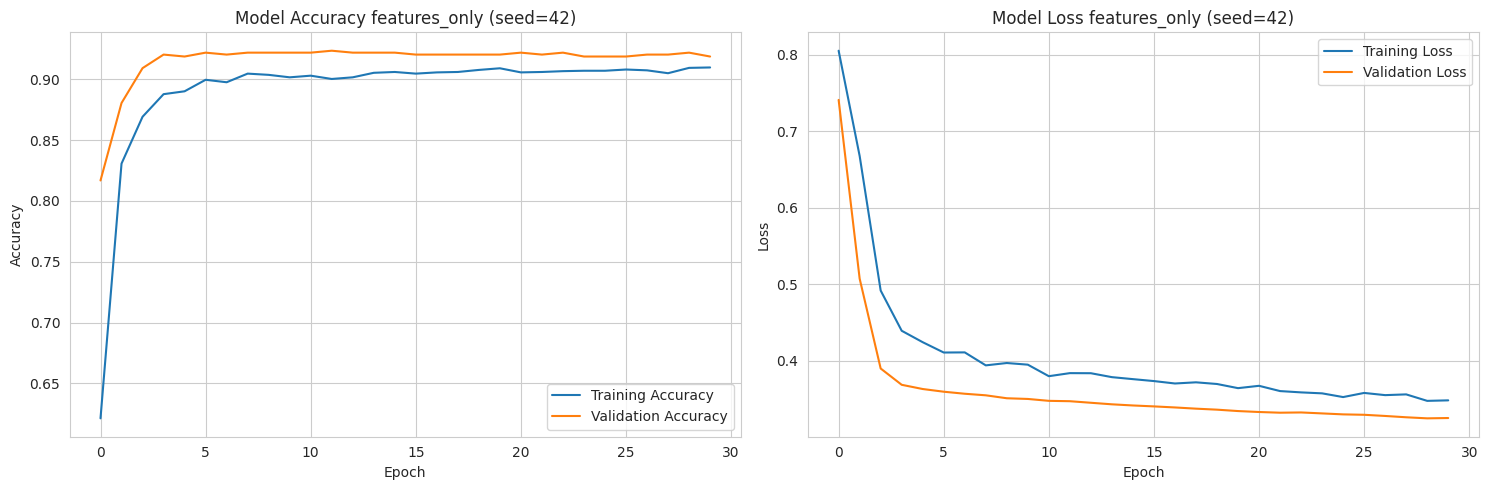


Final Training Accuracy: 0.9098
Final Validation Accuracy: 0.9188
Best Validation Accuracy: 0.9236

✓ Training complete
  Test Loss: 0.2999
  Test Accuracy: 0.9243

[Experiment 2/15] Seed 2/5: 123
✓ All random seeds set to 123

Training FEATURES_ONLY model (seed=123)
Parameters: 23,330
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5478 - loss: 0.8177 - val_accuracy: 0.7803 - val_loss: 0.7334 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7442 - loss: 0.7250 - val_accuracy: 0.8917 - val_loss: 0.5455 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8650 - loss: 0.5686 - val_accuracy: 0.9140 - val_loss: 0.4027 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8821 - loss: 0.4587 - val_accuracy: 0.9204 - val_loss: 0.3677 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8922 - loss: 0.4230 - val_accur

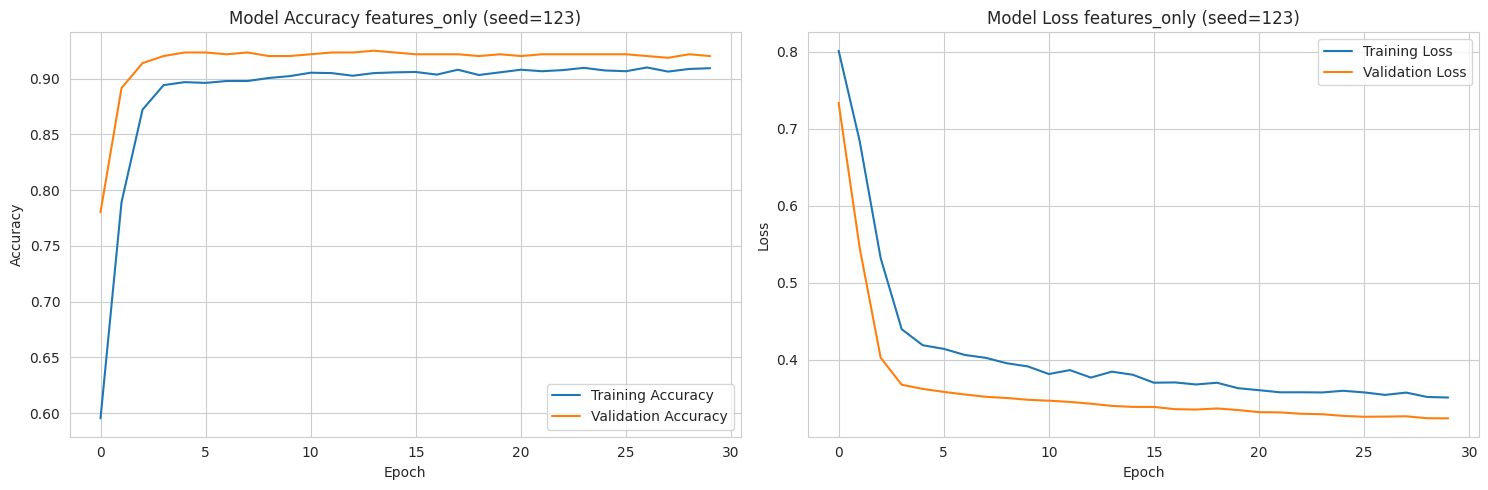


Final Training Accuracy: 0.9095
Final Validation Accuracy: 0.9204
Best Validation Accuracy: 0.9252

✓ Training complete
  Test Loss: 0.3005
  Test Accuracy: 0.9243

[Experiment 3/15] Seed 3/5: 456
✓ All random seeds set to 456

Training FEATURES_ONLY model (seed=456)
Parameters: 23,330
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6189 - loss: 0.8139 - val_accuracy: 0.8583 - val_loss: 0.7248 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8227 - loss: 0.7084 - val_accuracy: 0.8838 - val_loss: 0.5075 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8745 - loss: 0.5145 - val_accuracy: 0.9076 - val_loss: 0.4009 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8893 - loss: 0.4539 - val_accuracy: 0.9188 - val_loss: 0.3796 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8755 - loss: 0.4551 - val_accur

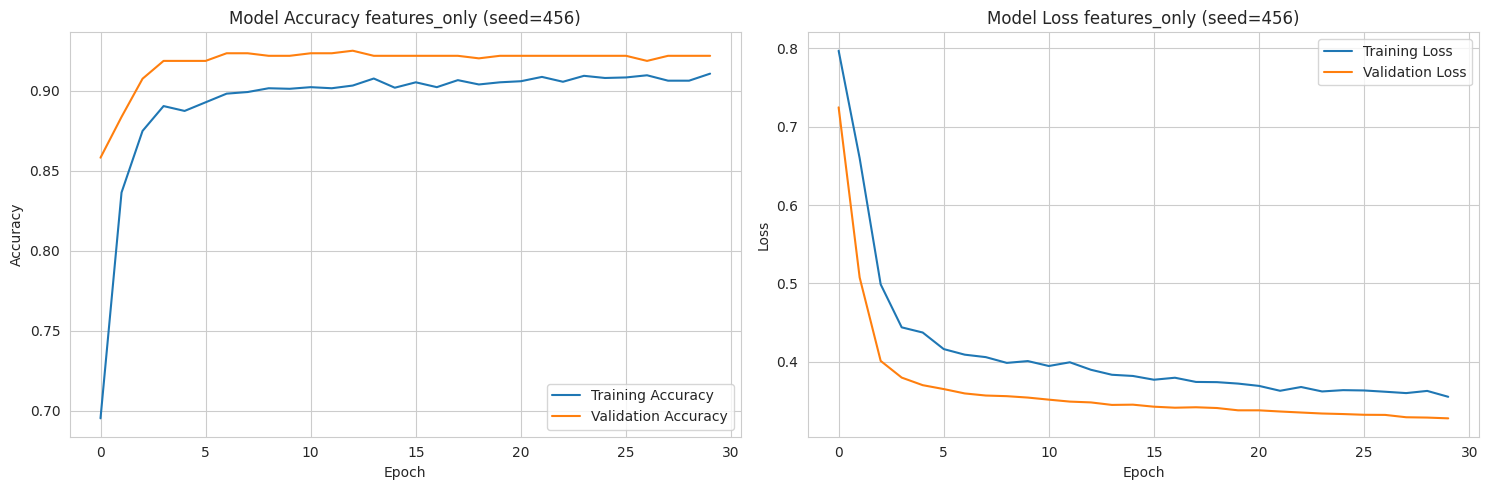


Final Training Accuracy: 0.9108
Final Validation Accuracy: 0.9220
Best Validation Accuracy: 0.9252

✓ Training complete
  Test Loss: 0.3041
  Test Accuracy: 0.9259

[Experiment 4/15] Seed 4/5: 789
✓ All random seeds set to 789

Training FEATURES_ONLY model (seed=789)
Parameters: 23,330
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5544 - loss: 0.8214 - val_accuracy: 0.8105 - val_loss: 0.7409 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7903 - loss: 0.7212 - val_accuracy: 0.9013 - val_loss: 0.5190 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8579 - loss: 0.5488 - val_accuracy: 0.9156 - val_loss: 0.3913 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8873 - loss: 0.4555 - val_accuracy: 0.9220 - val_loss: 0.3696 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8896 - loss: 0.4338 - val_accur

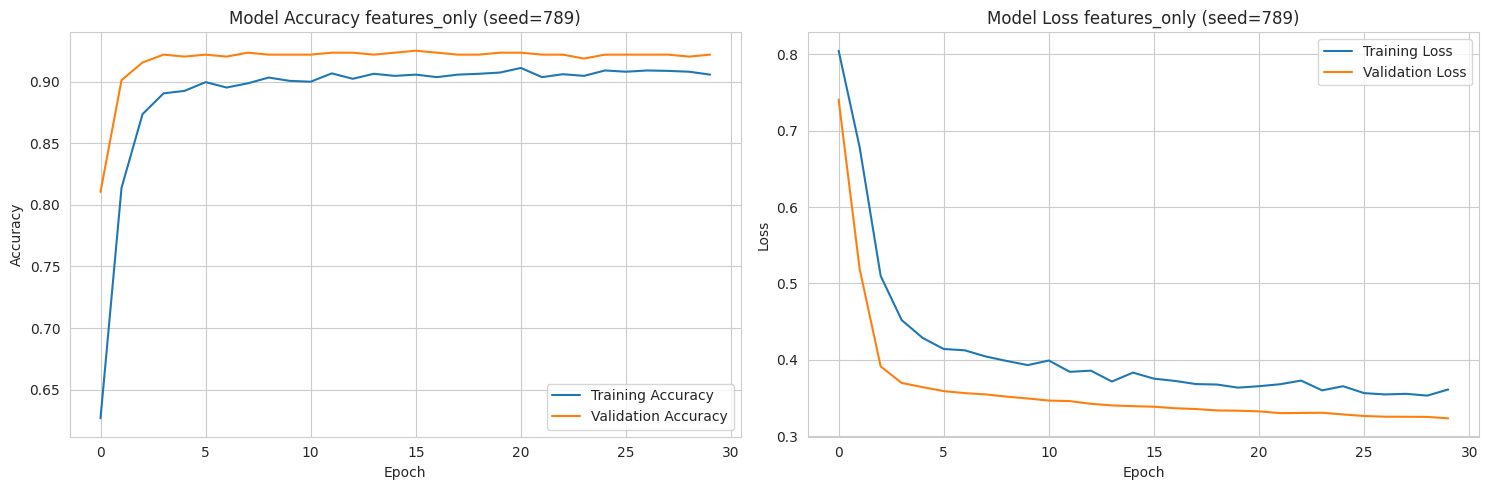


Final Training Accuracy: 0.9057
Final Validation Accuracy: 0.9220
Best Validation Accuracy: 0.9252

✓ Training complete
  Test Loss: 0.3006
  Test Accuracy: 0.9259

[Experiment 5/15] Seed 5/5: 1011
✓ All random seeds set to 1011

Training FEATURES_ONLY model (seed=1011)
Parameters: 23,330
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5233 - loss: 0.8219 - val_accuracy: 0.8376 - val_loss: 0.7608 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7872 - loss: 0.7393 - val_accuracy: 0.9092 - val_loss: 0.5268 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8575 - loss: 0.5366 - val_accuracy: 0.9092 - val_loss: 0.3924 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8715 - loss: 0.4680 - val_accuracy: 0.9204 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8959 - loss: 0.4172 - val_ac

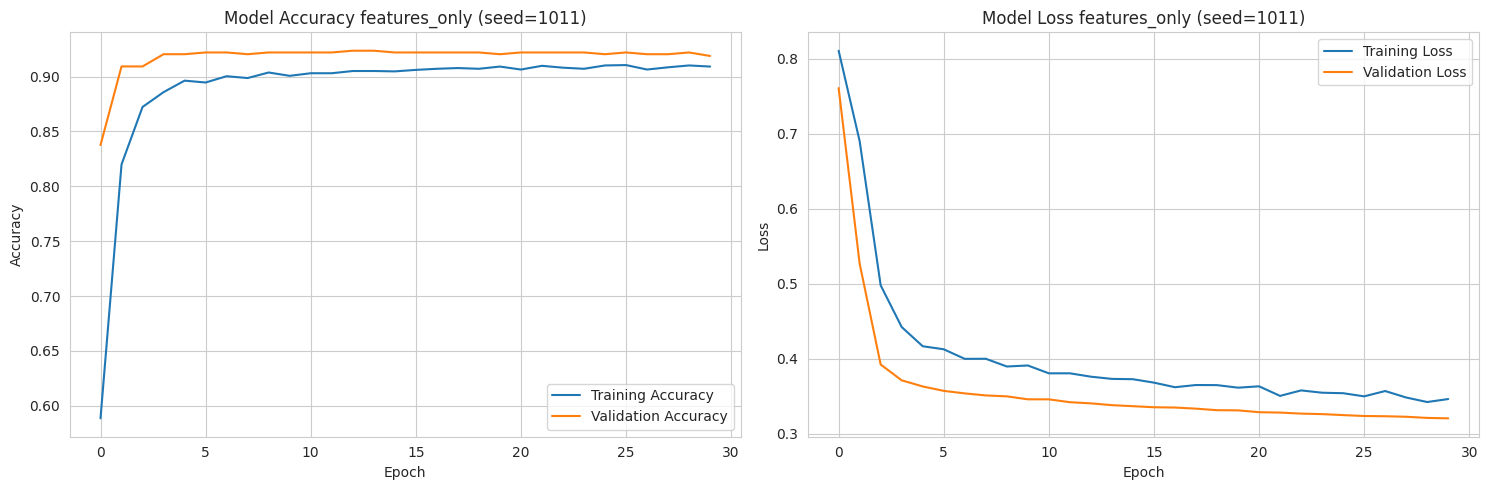


Final Training Accuracy: 0.9091
Final Validation Accuracy: 0.9188
Best Validation Accuracy: 0.9236

✓ Training complete
  Test Loss: 0.2962
  Test Accuracy: 0.9274

################################################################################
# Training HYBRID Model
################################################################################


[Experiment 6/15] Seed 1/5: 42
✓ All random seeds set to 42

Training HYBRID model (seed=42)
Parameters: 37,634
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5648 - loss: 0.8867 - val_accuracy: 0.6369 - val_loss: 0.8834 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8167 - loss: 0.7314 - val_accuracy: 0.8997 - val_loss: 0.8220 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9052 - loss: 0.5200 - val_accuracy: 0.8933 - val_loss: 0.7062 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.89

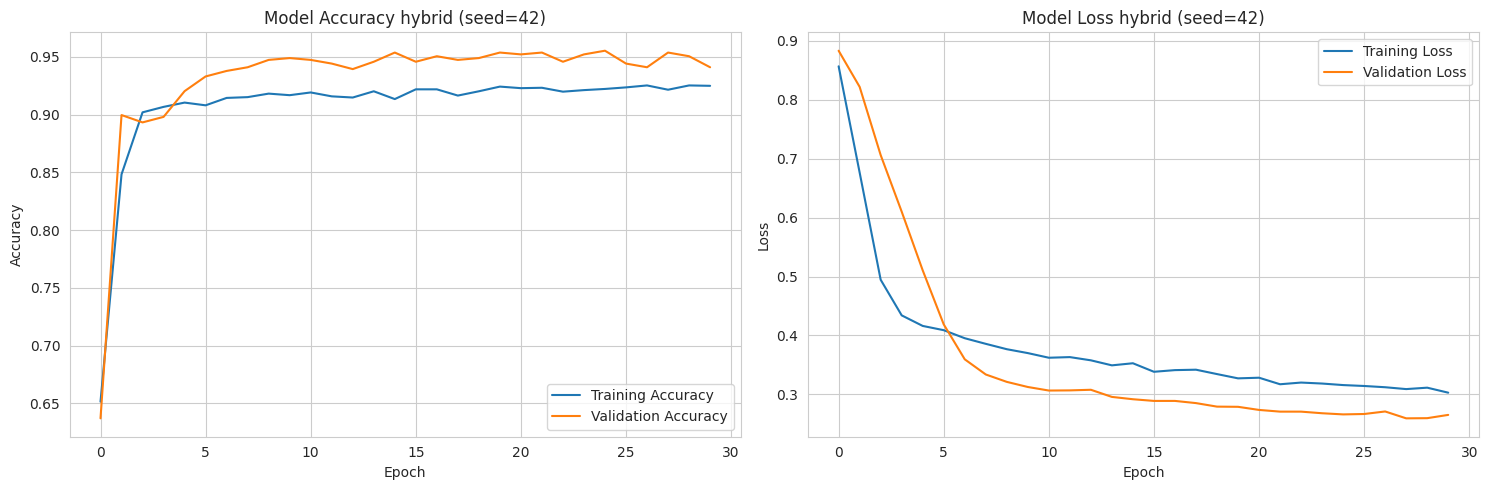


Final Training Accuracy: 0.9250
Final Validation Accuracy: 0.9411
Best Validation Accuracy: 0.9554

✓ Training complete
  Test Loss: 0.2855
  Test Accuracy: 0.9322

[Experiment 7/15] Seed 2/5: 123
✓ All random seeds set to 123

Training HYBRID model (seed=123)
Parameters: 37,634
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5199 - loss: 0.8960 - val_accuracy: 0.7389 - val_loss: 0.8818 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6790 - loss: 0.8032 - val_accuracy: 0.8217 - val_loss: 0.8261 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8396 - loss: 0.6315 - val_accuracy: 0.8583 - val_loss: 0.7110 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9036 - loss: 0.4672 - val_accuracy: 0.8742 - val_loss: 0.6126 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9108 - loss: 0.4213 - val_accu

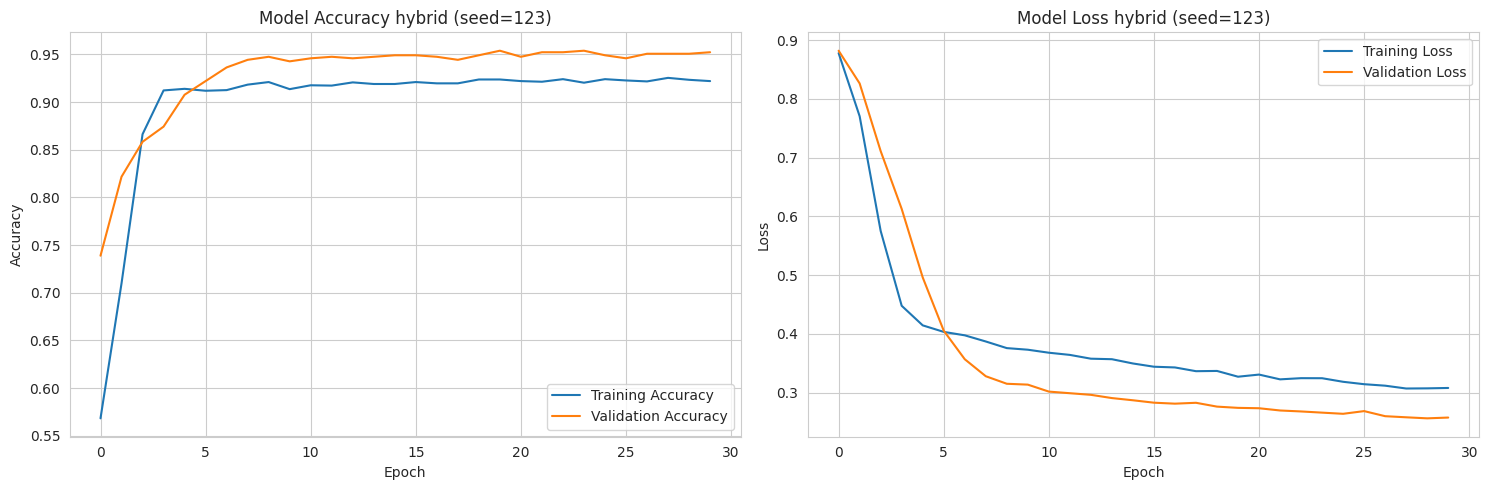


Final Training Accuracy: 0.9220
Final Validation Accuracy: 0.9522
Best Validation Accuracy: 0.9538

✓ Training complete
  Test Loss: 0.2842
  Test Accuracy: 0.9322

[Experiment 8/15] Seed 3/5: 456
✓ All random seeds set to 456

Training HYBRID model (seed=456)
Parameters: 37,634
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5415 - loss: 0.8968 - val_accuracy: 0.8232 - val_loss: 0.8729 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7323 - loss: 0.7808 - val_accuracy: 0.8583 - val_loss: 0.7946 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8698 - loss: 0.5645 - val_accuracy: 0.9156 - val_loss: 0.6703 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9045 - loss: 0.4568 - val_accuracy: 0.9268 - val_loss: 0.5819 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9102 - loss: 0.4361 - val_accu

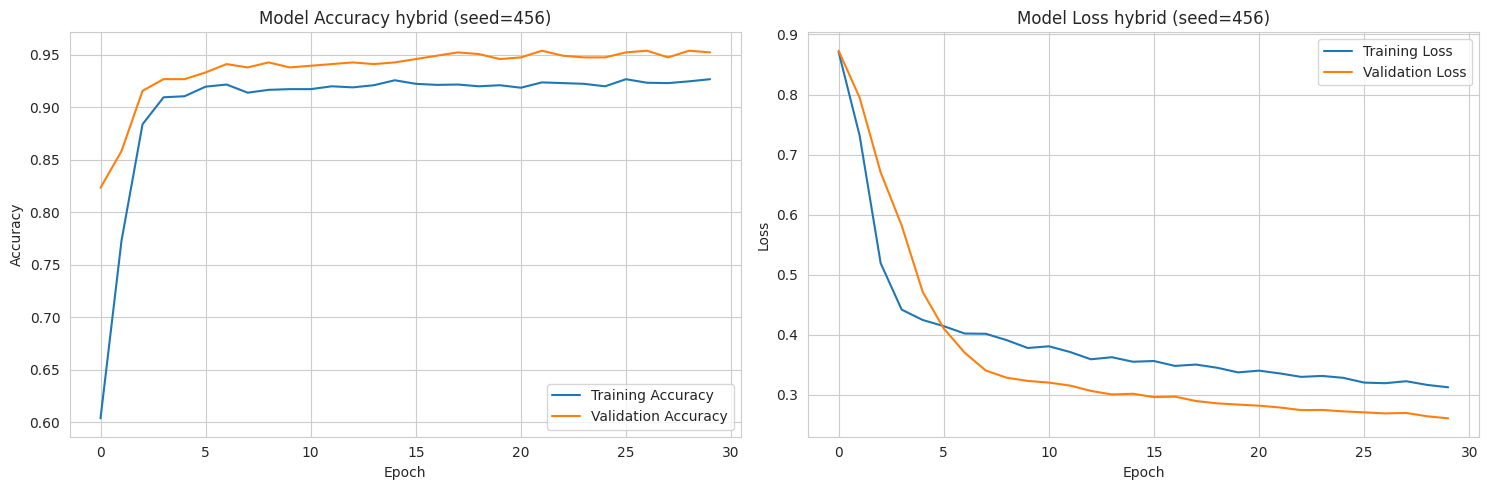


Final Training Accuracy: 0.9267
Final Validation Accuracy: 0.9522
Best Validation Accuracy: 0.9538

✓ Training complete
  Test Loss: 0.2882
  Test Accuracy: 0.9338

[Experiment 9/15] Seed 4/5: 789
✓ All random seeds set to 789

Training HYBRID model (seed=789)
Parameters: 37,634
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5538 - loss: 0.8818 - val_accuracy: 0.8631 - val_loss: 0.8773 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8022 - loss: 0.7245 - val_accuracy: 0.9188 - val_loss: 0.8122 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8844 - loss: 0.5196 - val_accuracy: 0.9220 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9034 - loss: 0.4484 - val_accuracy: 0.9188 - val_loss: 0.5747 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9097 - loss: 0.4273 - val_accura

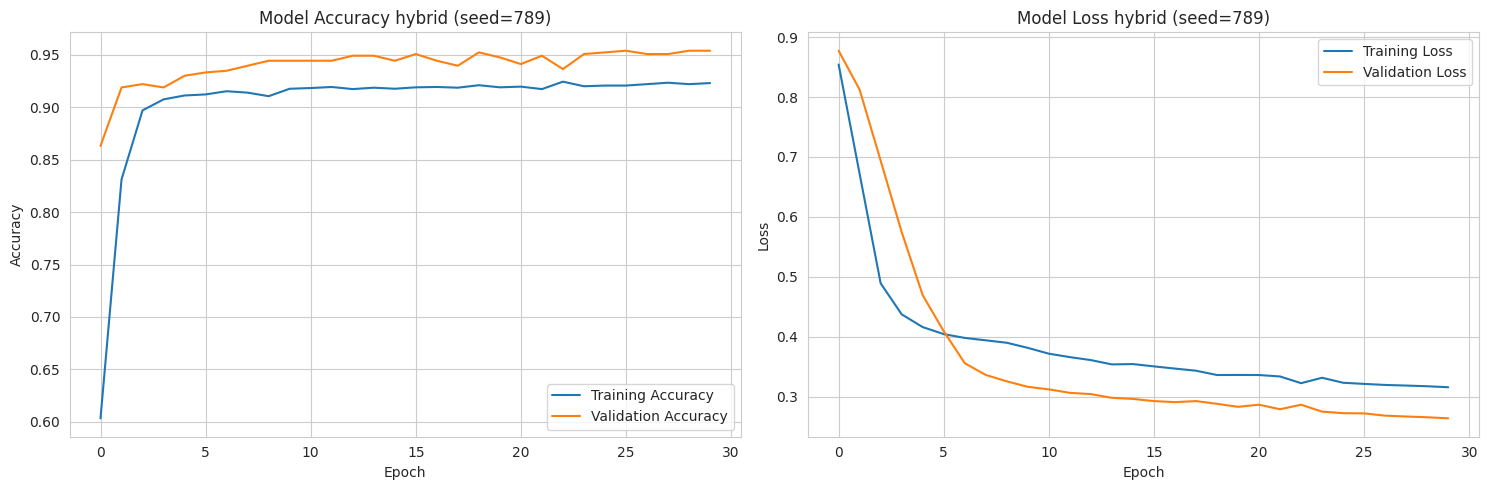


Final Training Accuracy: 0.9230
Final Validation Accuracy: 0.9538
Best Validation Accuracy: 0.9538

✓ Training complete
  Test Loss: 0.2895
  Test Accuracy: 0.9353

[Experiment 10/15] Seed 5/5: 1011
✓ All random seeds set to 1011

Training HYBRID model (seed=1011)
Parameters: 37,634
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.5839 - loss: 0.8837 - val_accuracy: 0.6768 - val_loss: 0.8784 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7087 - loss: 0.7838 - val_accuracy: 0.8981 - val_loss: 0.7939 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8714 - loss: 0.5748 - val_accuracy: 0.9236 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9013 - loss: 0.4704 - val_accuracy: 0.9236 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9129 - loss: 0.4205 - val_

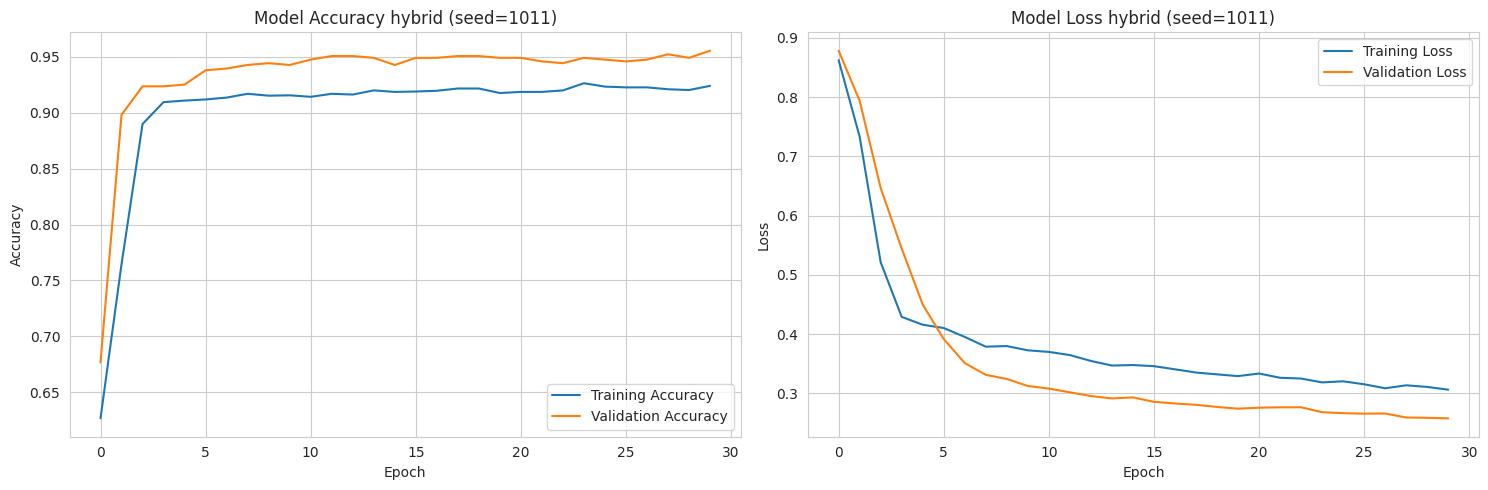


Final Training Accuracy: 0.9240
Final Validation Accuracy: 0.9554
Best Validation Accuracy: 0.9554

✓ Training complete
  Test Loss: 0.2857
  Test Accuracy: 0.9338

################################################################################
# Training IMAGE_ONLY Model
################################################################################


[Experiment 11/15] Seed 1/5: 42
✓ All random seeds set to 42

Training IMAGE_ONLY model (seed=42)
Parameters: 18,658
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5999 - loss: 0.7495 - val_accuracy: 0.4634 - val_loss: 0.7824 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7310 - loss: 0.6399 - val_accuracy: 0.6274 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8596 - loss: 0.4635 - val_accuracy: 0.5637 - val_loss: 0.7713 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accu

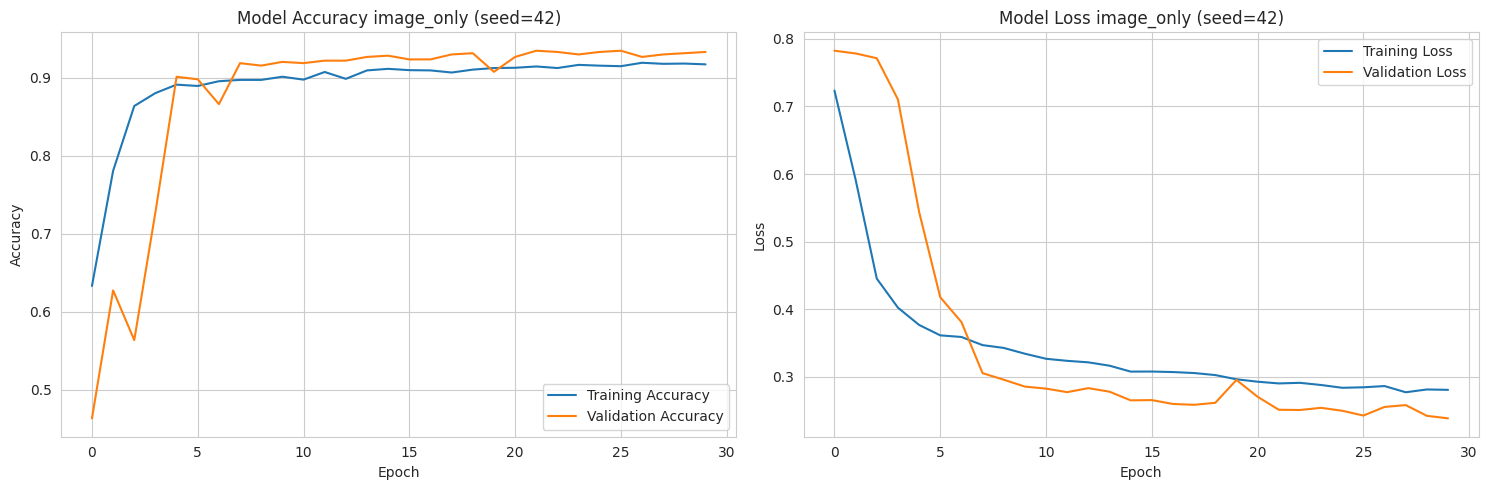


Final Training Accuracy: 0.9172
Final Validation Accuracy: 0.9331
Best Validation Accuracy: 0.9347

✓ Training complete
  Test Loss: 0.2641
  Test Accuracy: 0.9148

[Experiment 12/15] Seed 2/5: 123
✓ All random seeds set to 123

Training IMAGE_ONLY model (seed=123)
Parameters: 18,658
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5619 - loss: 0.7825 - val_accuracy: 0.4586 - val_loss: 0.7862 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6724 - loss: 0.6755 - val_accuracy: 0.4586 - val_loss: 0.7903 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8153 - loss: 0.5449 - val_accuracy: 0.4586 - val_loss: 0.7785 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8620 - loss: 0.4325 - val_accuracy: 0.6927 - val_loss: 0.6988 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8824 - loss: 0.3929 - va

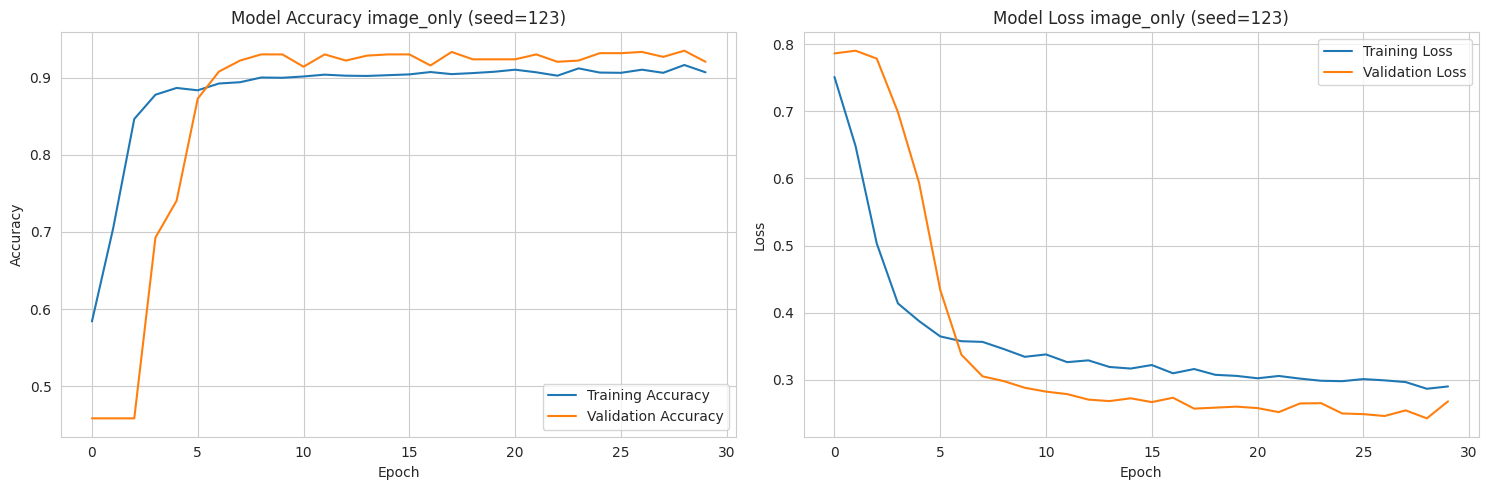


Final Training Accuracy: 0.9068
Final Validation Accuracy: 0.9204
Best Validation Accuracy: 0.9347

✓ Training complete
  Test Loss: 0.2679
  Test Accuracy: 0.9227

[Experiment 13/15] Seed 3/5: 456
✓ All random seeds set to 456

Training IMAGE_ONLY model (seed=456)
Parameters: 18,658
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5494 - loss: 0.7807 - val_accuracy: 0.4586 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7045 - loss: 0.6778 - val_accuracy: 0.4586 - val_loss: 0.7855 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8468 - loss: 0.4990 - val_accuracy: 0.4586 - val_loss: 0.7907 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8678 - loss: 0.4206 - val_accuracy: 0.5127 - val_loss: 0.7351 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8786 - loss: 0.3912 - val_

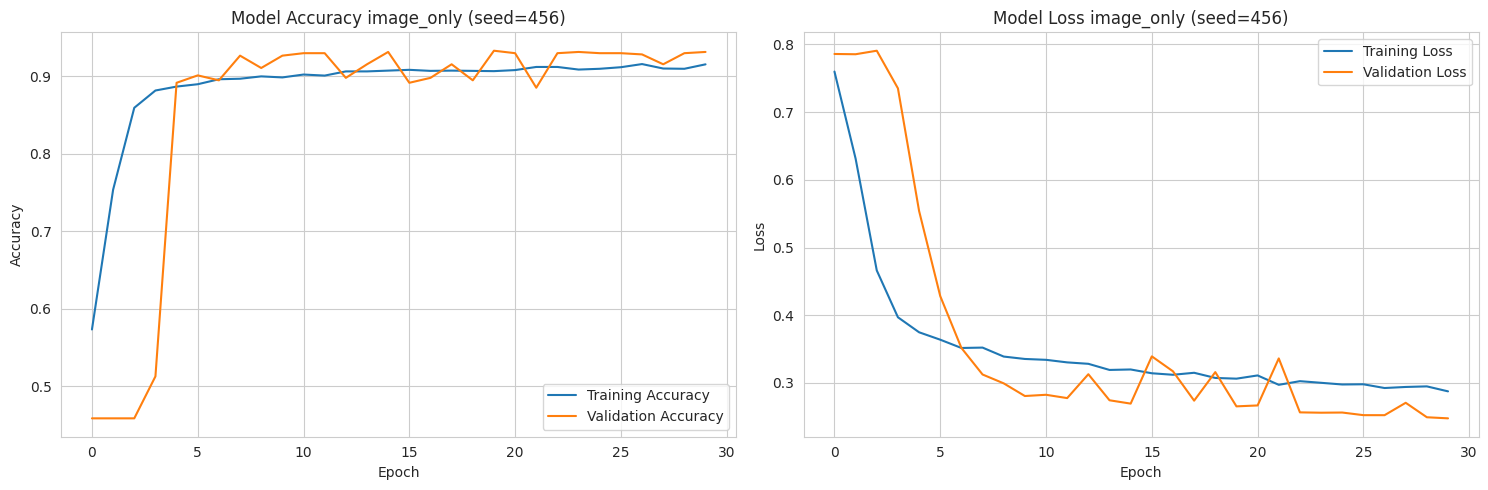


Final Training Accuracy: 0.9155
Final Validation Accuracy: 0.9315
Best Validation Accuracy: 0.9331

✓ Training complete
  Test Loss: 0.2779
  Test Accuracy: 0.9211

[Experiment 14/15] Seed 4/5: 789
✓ All random seeds set to 789

Training IMAGE_ONLY model (seed=789)
Parameters: 18,658
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5817 - loss: 0.7582 - val_accuracy: 0.4586 - val_loss: 0.7846 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7660 - loss: 0.6205 - val_accuracy: 0.6640 - val_loss: 0.7787 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8489 - loss: 0.4803 - val_accuracy: 0.5573 - val_loss: 0.7669 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8715 - loss: 0.4033 - val_accuracy: 0.6497 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8743 - loss: 0.3857 - val_

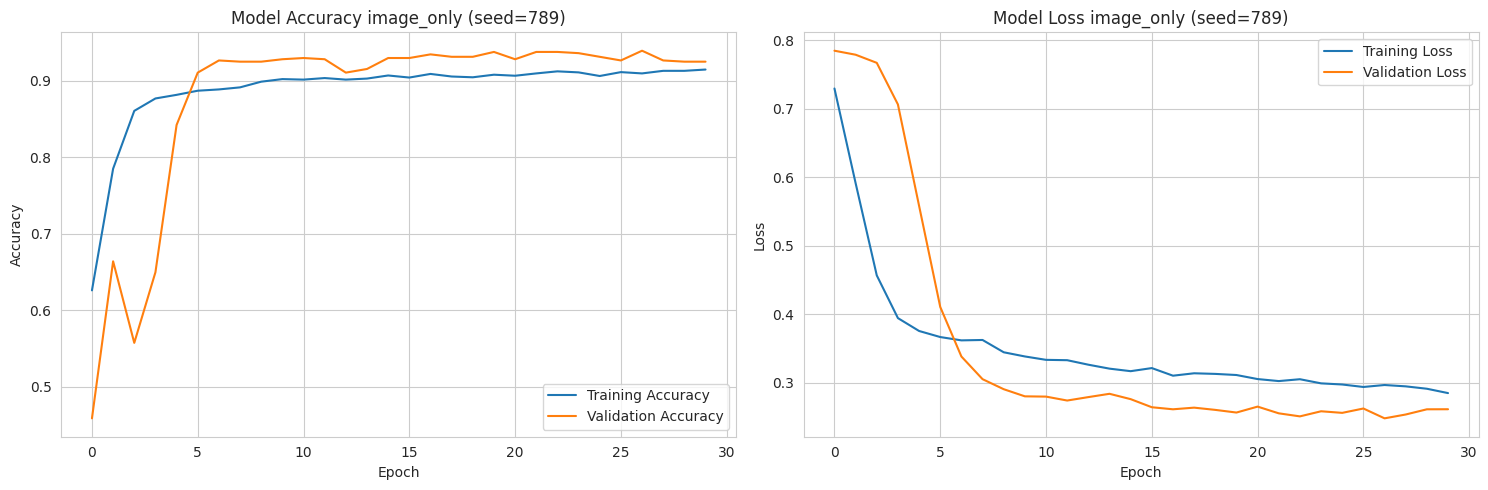


Final Training Accuracy: 0.9149
Final Validation Accuracy: 0.9252
Best Validation Accuracy: 0.9395

✓ Training complete
  Test Loss: 0.2752
  Test Accuracy: 0.9211

[Experiment 15/15] Seed 5/5: 1011
✓ All random seeds set to 1011

Training IMAGE_ONLY model (seed=1011)
Parameters: 18,658
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.4979 - loss: 0.8189 - val_accuracy: 0.5414 - val_loss: 0.7845 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.6844 - loss: 0.7013 - val_accuracy: 0.5414 - val_loss: 0.7791 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8514 - loss: 0.5057 - val_accuracy: 0.3599 - val_loss: 0.7834 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8753 - loss: 0.4097 - val_accuracy: 0.4984 - val_loss: 0.7693 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8942 - loss: 0.3745 - va

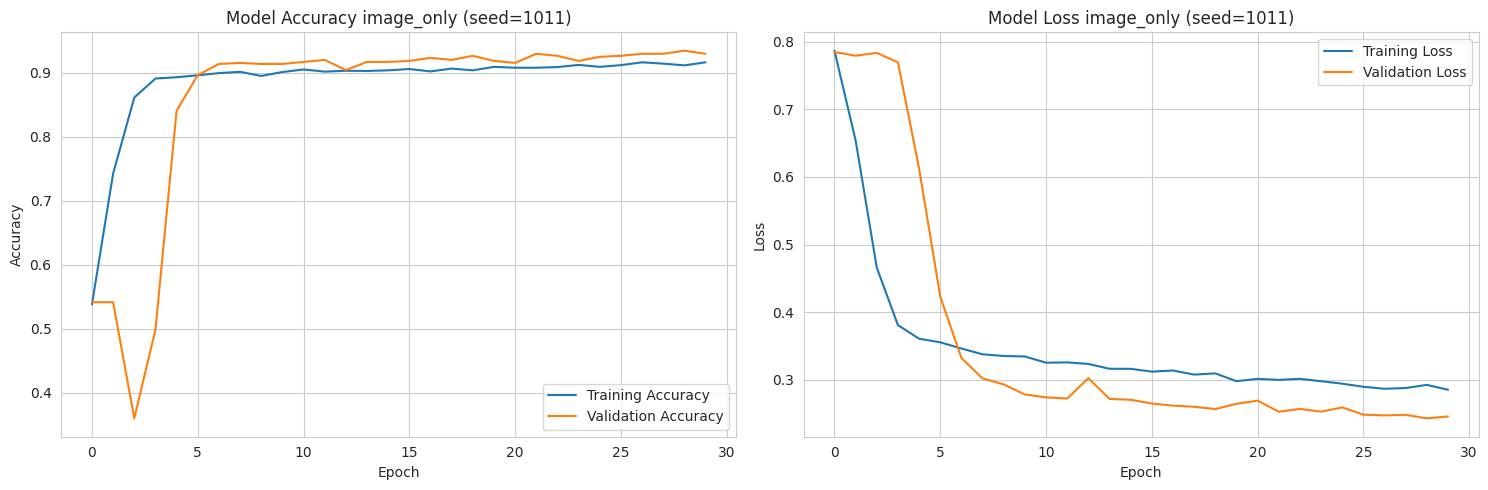


Final Training Accuracy: 0.9166
Final Validation Accuracy: 0.9299
Best Validation Accuracy: 0.9347

✓ Training complete
  Test Loss: 0.2648
  Test Accuracy: 0.9211

✓ Ablation study complete! Trained 15 models.



In [ ]:
# RUN THE FULL ABLATION STUDY
# This will take some time (training 15 models total)

ablation_results = run_ablation_study(
    data_splits=data_splits,
    model_types= MODEL_TYPES,
    random_seeds=RANDOM_SEEDS,
    class_weight_dict=class_weight_dict,
    **TRAINING_CONFIG
)

## 15. Analyze Results

In [ ]:
# Aggregate results across seeds
summary_df = aggregate_ablation_results(
    ablation_results,
    class_names=['Liquid', 'Solid']
)

print("\nAggregated Results:")
display(summary_df)


Aggregated Results:


,model,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,cohen_kappa_mean,cohen_kappa_std,precision_macro_mean,precision_macro_std,recall_macro_mean,...,Liquid_support_std,Solid_precision_mean,Solid_precision_std,Solid_recall_mean,Solid_recall_std,Solid_f1_mean,Solid_f1_std,Solid_support_mean,Solid_support_std,parameters
0,features_only,0.925552,0.001320,0.927340,0.001475,0.850779,0.002686,0.924771,0.001391,0.927340,...,0.0,0.895014,0.001367,0.949141,0.003764,0.921278,0.001540,291.0,0.0,23330
1,hybrid,0.933438,0.001320,0.935254,0.001503,0.866579,0.002691,0.932652,0.001392,0.935254,...,0.0,0.903375,0.001060,0.957388,0.003918,0.929593,0.001553,291.0,0.0,37634
2,image_only,0.920189,0.003075,0.920300,0.003497,0.839503,0.006308,0.919384,0.002942,0.920300,...,0.0,0.906137,0.005106,0.921649,0.010423,0.913782,0.003795,291.0,0.0,18658


In [ ]:
# Display comparison table
create_comparison_table(
    summary_df,
    metrics=['f1_macro', 'accuracy', 'cohen_kappa']
)


ABLATION STUDY RESULTS: Summary

Model         | Parameters | F1 Macro        | Accuracy        | Cohen Kappa    
--------------------------------------------------------------------------------
features_only | 23,330     | 0.9253 ± 0.0013 | 0.9256 ± 0.0013 | 0.8508 ± 0.0027
hybrid        | 37,634     | 0.9332 ± 0.0013 | 0.9334 ± 0.0013 | 0.8666 ± 0.0027
image_only    | 18,658     | 0.9197 ± 0.0031 | 0.9202 ± 0.0031 | 0.8395 ± 0.0063




✓ Plot saved to ablation_comparison.png


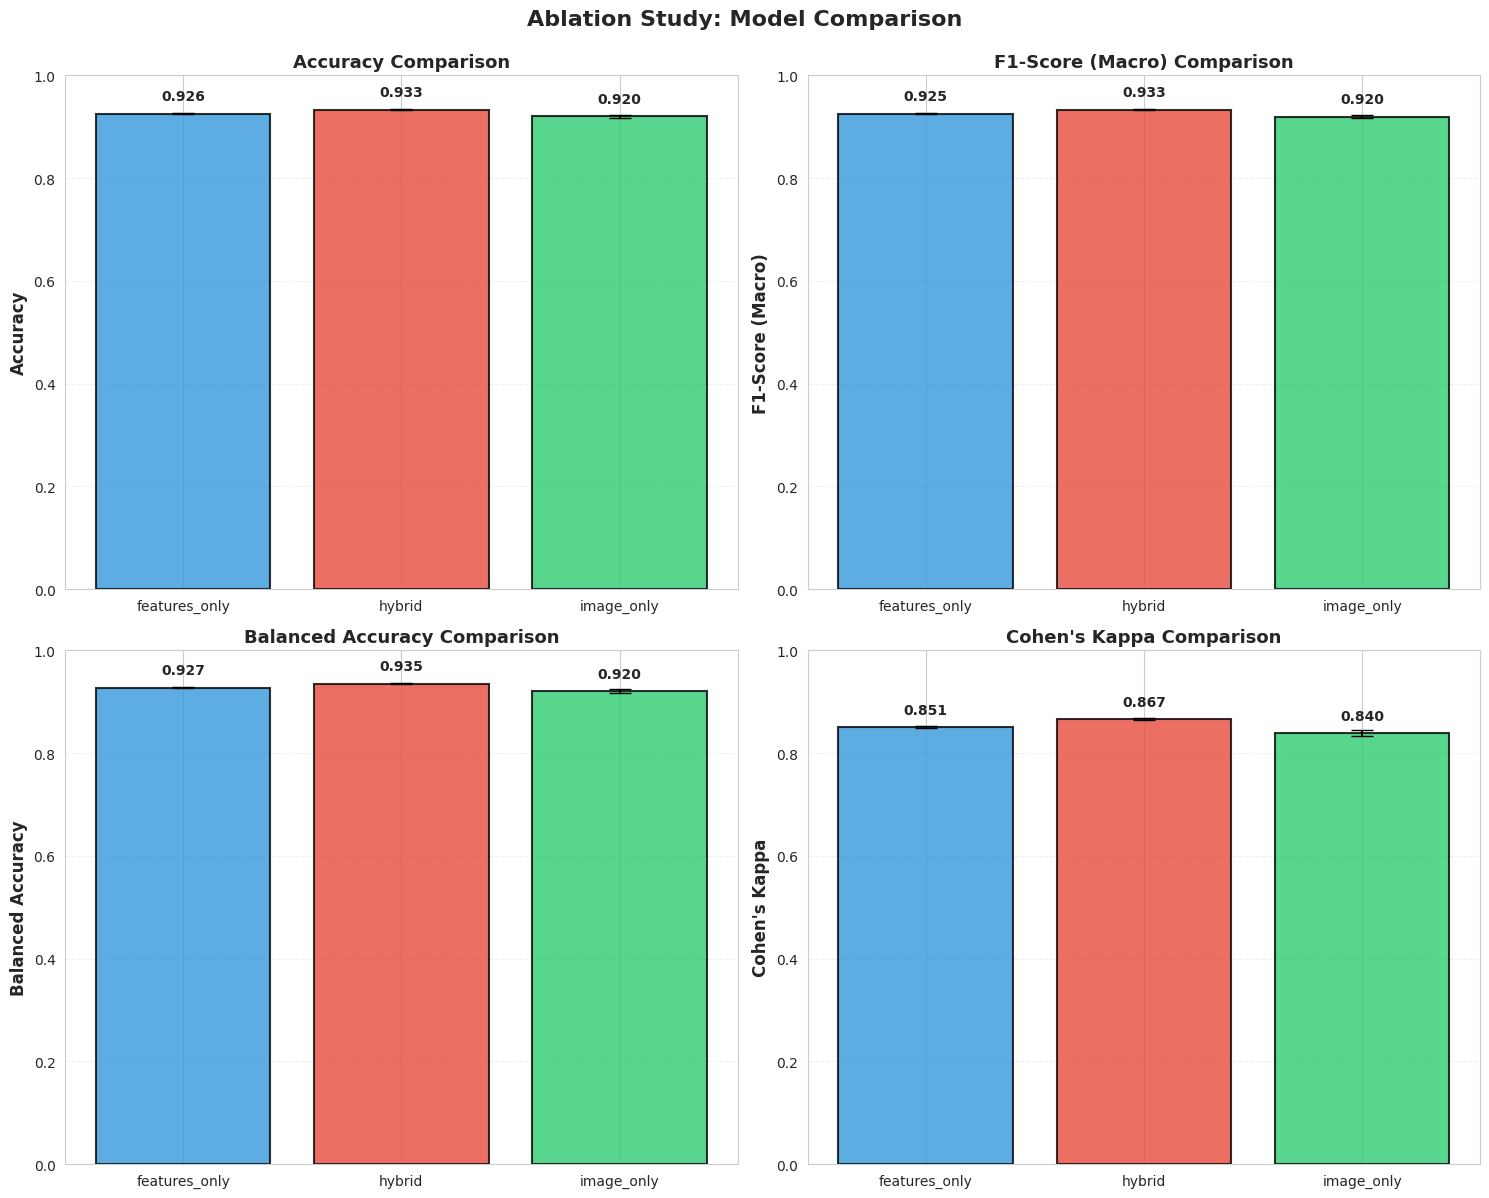

In [ ]:
# Create visualization
plot_ablation_results(summary_df, save_path='ablation_comparison.png')

## 16. Statistical Significance Testing

In [ ]:
# Test: Hybrid vs Image-only
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

p_hybrid_vs_image, _ = test_significance(
    ablation_results['hybrid'],
    ablation_results['image_only'],
    metric_key='test_accuracy',
    model1_name='Hybrid',
    model2_name='Image-only'
)


STATISTICAL SIGNIFICANCE TESTS

Statistical Significance Test: Hybrid vs Image-only
Metric: test_accuracy

Hybrid:
  Mean: 0.9259
  Std:  0.0000
  Scores: ['0.9259', '0.9259']

Image-only:
  Mean: 0.9180
  Std:  0.0000
  Scores: ['0.9180', '0.9180']

Paired t-test:
  t-statistic: inf
  p-value: 0.0000

Wilcoxon signed-rank test:
  W-statistic: 0.0000
  p-value: 0.5000

Conclusion:
  ✓✓✓ Difference is HIGHLY significant (p < 0.001)
  Hybrid is better by 0.0079 on average



/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:423: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
# Test: Hybrid vs Features-only
p_hybrid_vs_features, _ = test_significance(
    ablation_results['hybrid'],
    ablation_results['features_only'],
    metric_key='test_accuracy',
    model1_name='Hybrid',
    model2_name='Features-only'
)


Statistical Significance Test: Hybrid vs Features-only
Metric: test_accuracy

Hybrid:
  Mean: 0.9334
  Std:  0.0012
  Scores: ['0.9322', '0.9322', '0.9338', '0.9353', '0.9338']

Features-only:
  Mean: 0.9256
  Std:  0.0012
  Scores: ['0.9243', '0.9243', '0.9259', '0.9259', '0.9274']

Paired t-test:
  t-statistic: 15.8114
  p-value: 0.0001

Wilcoxon signed-rank test:
  W-statistic: 0.0000
  p-value: 0.0625

Conclusion:
  ✓✓✓ Difference is HIGHLY significant (p < 0.001)
  Hybrid is better by 0.0079 on average



In [ ]:
# Test: Image-only vs Features-only
p_image_vs_features, _ = test_significance(
    ablation_results['image_only'],
    ablation_results['features_only'],
    metric_key='test_accuracy',
    model1_name='Image-only',
    model2_name='Features-only'
)


Statistical Significance Test: Image-only vs Features-only
Metric: test_accuracy

Image-only:
  Mean: 0.9202
  Std:  0.0028
  Scores: ['0.9148', '0.9227', '0.9211', '0.9211', '0.9211']

Features-only:
  Mean: 0.9256
  Std:  0.0012
  Scores: ['0.9243', '0.9243', '0.9259', '0.9259', '0.9274']

Paired t-test:
  t-statistic: -4.1851
  p-value: 0.0139

Wilcoxon signed-rank test:
  W-statistic: 0.0000
  p-value: 0.0625

Conclusion:
  ✓ Difference is significant (p < 0.05)
  Features-only is better by 0.0054 on average



## 17. Per-Class Performance Analysis

In [ ]:
# Analyze per-class performance for each model
class_names = ['Liquid', 'Solid']

print(f"\n{'='*80}")
print(f"PER-CLASS PERFORMANCE ANALYSIS")
print(f"{'='*80}\n")

for model_type in MODEL_TYPES:
    print(f"\n{model_type.upper()}:")
    print(f"{'-'*60}")

    # Get metrics for each class across all seeds
    for class_name in class_names:
        f1_scores = []
        for run in ablation_results[model_type]:
            metrics = compute_comprehensive_metrics(
                run['y_true'], run['y_pred'], run['y_pred_probs'], class_names
            )
            f1_scores.append(metrics[f'{class_name}_f1'])

        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)

        print(f"  {class_name:10s} F1: {mean_f1:.4f} ± {std_f1:.4f}")

print(f"\n{'='*80}\n")


PER-CLASS PERFORMANCE ANALYSIS


FEATURES_ONLY:
------------------------------------------------------------
  Liquid     F1: 0.9294 ± 0.0010
  Solid      F1: 0.9213 ± 0.0014

HYBRID:
------------------------------------------------------------
  Liquid     F1: 0.9369 ± 0.0010
  Solid      F1: 0.9296 ± 0.0014

IMAGE_ONLY:
------------------------------------------------------------
  Liquid     F1: 0.9257 ± 0.0023
  Solid      F1: 0.9138 ± 0.0034




## 18. Confusion Matrices

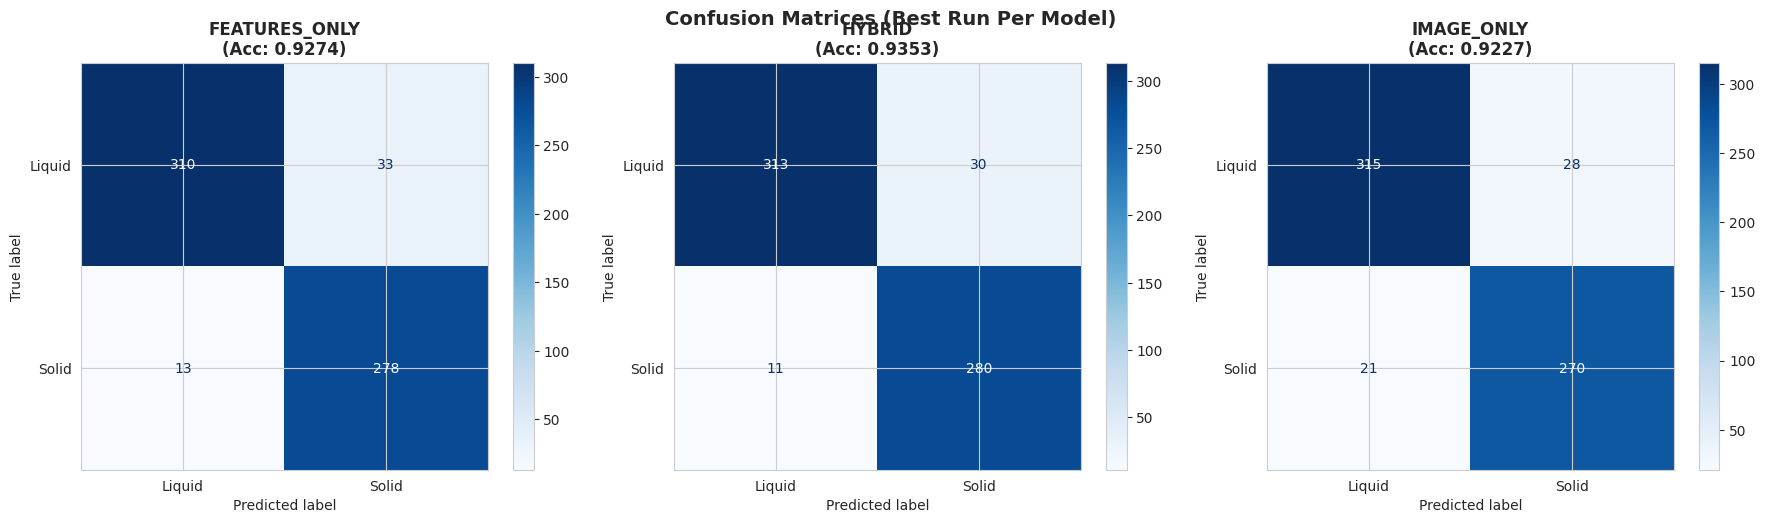

In [ ]:
# Plot confusion matrices for best model of each type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_type in enumerate(MODEL_TYPES):
    # Get best run (highest accuracy)
    best_run = max(ablation_results[model_type], key=lambda x: x['test_accuracy'])

    # Get confusion matrix
    cm = confusion_matrix(best_run['y_true'], best_run['y_pred'])

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_type.upper()}\n(Acc: {best_run["test_accuracy"]:.4f})', fontweight='bold')

plt.suptitle('Confusion Matrices (Best Run Per Model)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Needed for creating temporary DataFrame for plotting

def plot_confidence_analysis(ablation_results, model_types, save_path='confidence_analysis.png'):
    """
    Plots the distribution of prediction confidence (max probability)
    for correct vs incorrect predictions for the best run of each model type.
    """
    fig, axes = plt.subplots(1, len(model_types), figsize=(6 * len(model_types), 6))

    # Ensure axes is iterable even for a single model
    if len(model_types) == 1:
        axes = [axes]

    for idx, model_type in enumerate(model_types):
        # 1. Get best run (highest test accuracy)
        best_run = max(ablation_results[model_type], key=lambda x: x['test_accuracy'])

        y_true = best_run['y_true']
        y_pred_probs = best_run['y_pred_probs']

        # Determine predicted labels
        y_pred = np.argmax(y_pred_probs, axis=1)

        # 2. Calculate Maximum Confidence and Correctness
        max_confidence = np.max(y_pred_probs, axis=1)
        is_correct = (y_true == y_pred)

        # Create a DataFrame for easy seaborn plotting
        df_conf = pd.DataFrame({
            'Confidence': max_confidence,
            'Prediction': np.where(is_correct, 'Correct', 'Incorrect')
        })

        # 3. Plotting (KDE plot is used for smooth distribution)
        sns.kdeplot(
            data=df_conf,
            x='Confidence',
            hue='Prediction',
            fill=True,
            common_norm=False,
            palette={'Correct': 'green', 'Incorrect': 'red'},
            alpha=0.6,
            linewidth=2,
            ax=axes[idx]
        )

        # Calculate summary statistics for the plot title
        correct_mean_conf = df_conf[df_conf['Prediction'] == 'Correct']['Confidence'].mean()
        incorrect_mean_conf = df_conf[df_conf['Prediction'] == 'Incorrect']['Confidence'].mean()

        # Set titles and labels
        title = f'{model_type.upper()} Confidence Analysis\n(Acc: {best_run["test_accuracy"]:.4f})'
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].set_xlabel('Predicted Class Confidence', fontweight='bold')
        axes[idx].set_ylabel('Density', fontweight='bold')
        axes[idx].set_xlim(0.5, 1.0) # Confidences must be > 0.5 to be a prediction
        axes[idx].grid(axis='y', alpha=0.3)

        # Add text box for mean confidence (helpful for direct comparison)
        if not np.isnan(correct_mean_conf) and not np.isnan(incorrect_mean_conf):
            text_str = (f'Mean Conf (Correct): {correct_mean_conf:.3f}\n'
                        f'Mean Conf (Incorrect): {incorrect_mean_conf:.3f}')
            props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
            axes[idx].text(0.05, 0.95, text_str, transform=axes[idx].transAxes,
                            fontsize=10, verticalalignment='top', bbox=props)


    plt.suptitle('Model Confidence Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Confidence analysis plot saved to {save_path}")

In [ ]:

# Convert the path array to a list for matching
X_paths_test_list = data_splits['X_paths_test'].tolist()

# 1. Create a Series mapping path to diameter
path_to_diam = df_filtered_with_images.set_index(df_filtered_with_images.apply(
    lambda row: get_image_path(row, base_path), axis=1)
)['diam']

# 2. Extract diameters for the test set paths, maintaining order
# Note: This assumes all paths in X_paths_test exist in the path_to_diam series index.
test_diameters = path_to_diam.loc[X_paths_test_list].values

print(f"Test diameter array successfully created with shape: {test_diameters.shape}")



Test diameter array successfully created with shape: (634,)


In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List
from collections import defaultdict
from sklearn.metrics import accuracy_score
import re # Needed for string cleaning


def evaluate_by_size_bin(ablation_results: Dict[str, List[Dict]],
                         model_types: List[str],
                         test_diameters: np.ndarray,
                         size_threshold: float = 150.0) -> pd.DataFrame:
    """
    Evaluates the accuracy of each model across different particle size bins
    and returns a structured DataFrame for the discussion table.
    """

    # 1. Define size masks for the test set
    mask_small = test_diameters < size_threshold
    mask_large = test_diameters >= size_threshold

    # Check if masks are empty (shouldn't happen with proper splitting)
    if mask_small.sum() == 0 or mask_large.sum() == 0:
        print("Warning: One of the particle size bins is empty. Check data distribution.")

    results = defaultdict(lambda: defaultdict(list))

    # Loop through each model type and each seed run
    for model_type in model_types:
        for run in ablation_results[model_type]:
            # Extract necessary data (y_true and y_pred are integer labels)
            y_true = run['y_true']
            y_pred = run['y_pred']
            y_pred_probs = run['y_pred_probs'] # Needed for compute_comprehensive_metrics

            # --- Evaluate All Particles ---
            # NOTE: We use compute_comprehensive_metrics to rely on your existing definition,
            # but slicing y_pred_probs is technically redundant for just calculating accuracy.
            metrics_all = compute_comprehensive_metrics(y_true, y_pred, y_pred_probs, class_names=['Liquid', 'Solid'])
            results[model_type]['All Particles'].append(metrics_all['accuracy'])

            # --- Evaluate Small Particles ---
            y_true_small = y_true[mask_small]
            y_pred_small = y_pred[mask_small]
            y_pred_probs_small = y_pred_probs[mask_small]
            metrics_small = compute_comprehensive_metrics(y_true_small, y_pred_small, y_pred_probs_small, class_names=['Liquid', 'Solid'])
            results[model_type][f'< {size_threshold} \mu m'].append(metrics_small['accuracy'])

            # --- Evaluate Large Particles ---
            y_true_large = y_true[mask_large]
            y_pred_large = y_pred[mask_large]
            y_pred_probs_large = y_pred_probs[mask_large]
            metrics_large = compute_comprehensive_metrics(y_true_large, y_pred_large, y_pred_probs_large, class_names=['Liquid', 'Solid'])
            results[model_type][f'> {size_threshold} \mu m'].append(metrics_large['accuracy'])

    # 2. Aggregate and Format Results
    final_data = []
    # Map model type to discussion table name
    model_map = {'features_only': 'Geometric-only', 'image_only': 'Image-only', 'hybrid': r'\textbf{Hybrid}'}

    # Define column order for the final table
    col_small = f'$< {size_threshold} \mu m$'
    col_large = f'$> {size_threshold} \mu m$'
    column_order = ['Model', 'All Particles', col_small, col_large]

    for model_type, metrics in results.items():
        row = {'Model': model_map.get(model_type, model_type.title())}
        # Calculate mean accuracy across all seeds and format as percentage
        row['All Particles'] = f'{np.mean(metrics["All Particles"]):.1%}'
        row[col_small] = f'{np.mean(metrics[f"< {size_threshold} \mu m"]):.1%}'
        row[col_large] = f'{np.mean(metrics[f"> {size_threshold} \mu m"]):.1%}'
        final_data.append(row)

    df = pd.DataFrame(final_data)
    df = df[column_order]

    # Reorder rows: Image-only, Geometric-only, Hybrid
    model_order = [r'\textbf{Hybrid}', 'Image-only', 'Geometric-only'] # Order is Hybrid last, but need to calculate improvement based on Image-only.

    # 3. Calculate Improvement Row (Hybrid - Image-only)

    # Helper to convert formatted string back to float
    def to_float(s):
        # Remove LaTeX and percentage signs, convert to float
        return float(re.sub(r'\\textbf{|\%|\}|\$|\\mu m', '', s)) / 100.0

    # Locate rows for calculation (before reordering)
    hybrid_row = df[df['Model'] == r'\textbf{Hybrid}'].iloc[0]
    image_row = df[df['Model'] == 'Image-only'].iloc[0]

    improvement_row = {'Model': r'\textit{Improvement}'}

    for col in column_order[1:]:
        hybrid_acc = to_float(hybrid_row[col])
        image_acc = to_float(image_row[col])
        improvement = hybrid_acc - image_acc
        improvement_row[col] = r'\textit{+' + f'{improvement:.1%}' + r'}'

    # Reorder rows for final presentation
    df['Model_Order'] = df['Model'].apply(lambda x: 0 if 'Hybrid' in x else (1 if 'Image-only' in x else 2))
    df = df.sort_values('Model_Order').drop(columns=['Model_Order'])

    # Add improvement row and remove the Hybrid formatting for the table layout
    df = pd.concat([df, pd.Series(improvement_row).to_frame().T], ignore_index=True)

    # Remove \textbf{} from Hybrid model for final display, then re-add it in print for LaTeX
    df.loc[df['Model'].str.contains('Hybrid'), 'Model'] = 'Hybrid'

    return df

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3588686067.py:47: SyntaxWarning: invalid escape sequence '\m'
  results[model_type][f'< {size_threshold} \mu m'].append(metrics_small['accuracy'])
/tmp/ipython-input-3588686067.py:54: SyntaxWarning: invalid escape sequence '\m'
  results[model_type][f'> {size_threshold} \mu m'].append(metrics_large['accuracy'])
/tmp/ipython-input-3588686067.py:62: SyntaxWarning: inva

In [ ]:
# --- Execution Block (assuming all necessary variables are defined in your environment) ---

# Example initialization of variables needed for the function to run:
# NOTE: The values below are placeholders based on the desired output table structure.
# You must ensure your actual data (ablation_results, test_diameters) is used.
# Call the function to generate the final DataFrame
final_ablation_table = evaluate_by_size_bin(
    ablation_results=ablation_results,
    model_types=MODEL_TYPES,
    test_diameters=test_diameters,
    size_threshold=150.0
)

print("\n--- Final Ablation Table (DataFrame) ---")
print(final_ablation_table)



--- Final Ablation Table (DataFrame) ---
                  Model   All Particles $< 150.0 \mu m$ $> 150.0 \mu m$
0                Hybrid           93.3%           92.5%           94.0%
1            Image-only           92.0%           91.3%           92.6%
2        Geometric-only           92.6%           91.0%           93.8%
3  \textit{Improvement}  \textit{+1.3%}  \textit{+1.2%}  \textit{+1.4%}


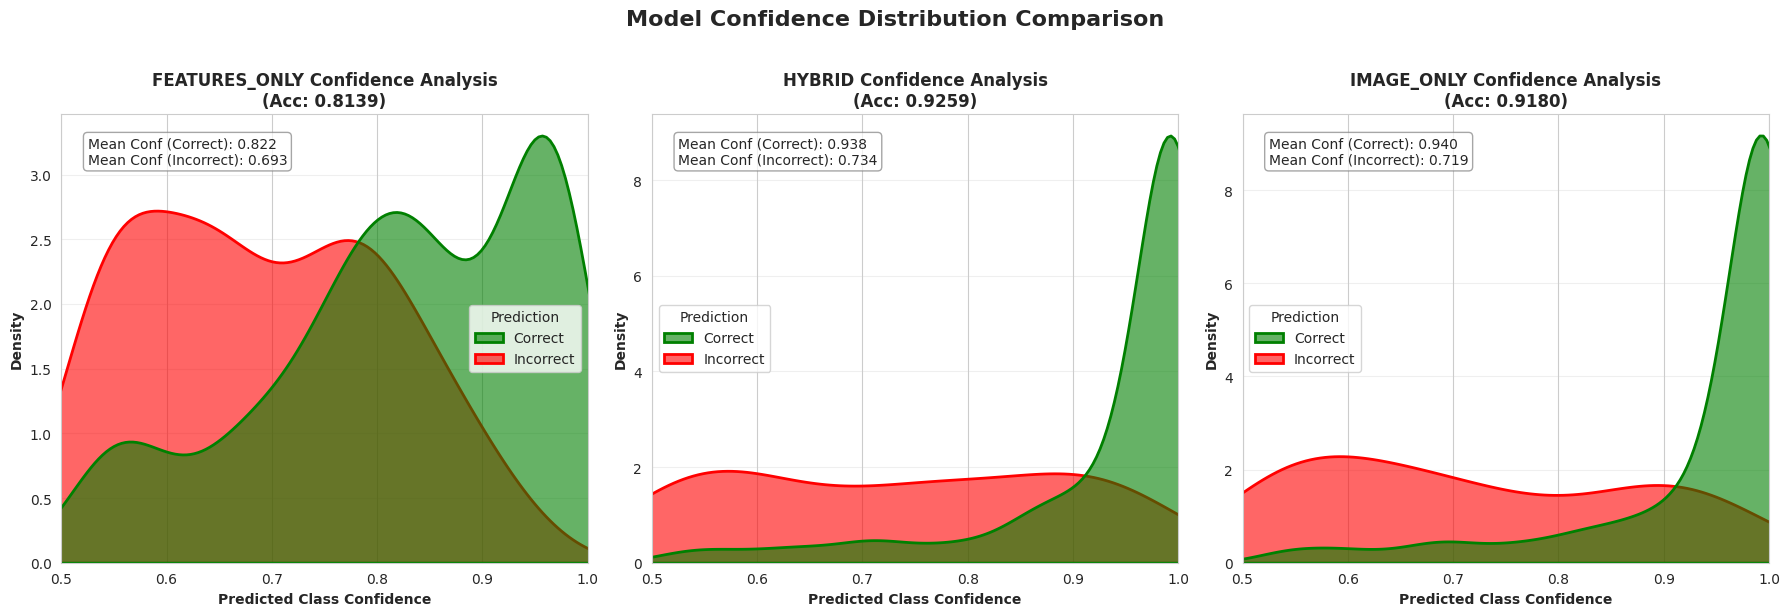

✓ Confidence analysis plot saved to confidence_analysis_comparison.png


In [ ]:
# Assuming ablation_results and MODEL_TYPES are defined after running the study

plot_confidence_analysis(
    ablation_results,
    model_types=MODEL_TYPES,
    save_path='confidence_analysis_comparison.png'
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confidence_by_size(ablation_results, model_types, test_diameters, save_path='confidence_boxplot_by_size.png'):
    """
    Plots confidence boxplots based on particle size bins (quartiles) for the best run of each model type.
    """

    # --- 1. Define Size Bins (Quartiles) ---
    # Using test set quartiles for binning ensures a balanced sample distribution per bin
    q_bins = np.quantile(test_diameters, [0, 0.25, 0.5, 0.75, 1.0])
    size_labels = ['Small (Q1)', 'Medium (Q2)', 'Medium-Large (Q3)', 'Large (Q4)']

    # --- 2. Aggregate Data for Plotting ---
    all_plot_data = []

    for model_type in model_types:
        # Get best run (highest test accuracy)
        best_run = max(ablation_results[model_type], key=lambda x: x['test_accuracy'])

        y_true = best_run['y_true']
        y_pred_probs = best_run['y_pred_probs']

        # Determine max confidence for the predicted class
        max_confidence = np.max(y_pred_probs, axis=1)

        # Check data length alignment (crucial)
        if len(test_diameters) != len(y_true):
            print(f"Error: Diameter data ({len(test_diameters)}) length mismatch with test set predictions ({len(y_true)}). Skipping {model_type}.")
            continue

        # Bin the diameters
        # pd.cut automatically includes the lowest value
        size_bins = pd.cut(test_diameters, bins=q_bins, labels=size_labels, include_lowest=True)

        df_model = pd.DataFrame({
            'Model': model_type.upper(),
            'Confidence': max_confidence,
            'Size_Bin': size_bins
        })
        all_plot_data.append(df_model)

    if not all_plot_data:
        print("No data available for plotting.")
        return

    df_combined = pd.concat(all_plot_data)

    # --- 3. Plotting ---
    plt.figure(figsize=(16, 7))

    sns.boxplot(
        data=df_combined,
        x='Size_Bin',
        y='Confidence',
        hue='Model',
        palette={'HYBRID': '#3498db', 'IMAGE_ONLY': '#e74c3c', 'FEATURES_ONLY': '#2ecc71'},
        notch=False,
        linewidth=1.5,
        fliersize=3
    )

    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Decision Boundary (0.5)')

    plt.ylim(0.45, 1.0) # Focus on the decision range
    plt.xlabel('Particle Diameter Bin (Based on Test Set Quartiles)', fontweight='bold', fontsize=12)
    plt.ylabel('Prediction Confidence (Max Probability)', fontweight='bold', fontsize=12)
    plt.title('Model Prediction Confidence Distribution by Particle Size', fontweight='bold', fontsize=14)
    plt.legend(title='Model Type', loc='lower left')
    plt.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Confidence boxplot by size saved to {save_path}")

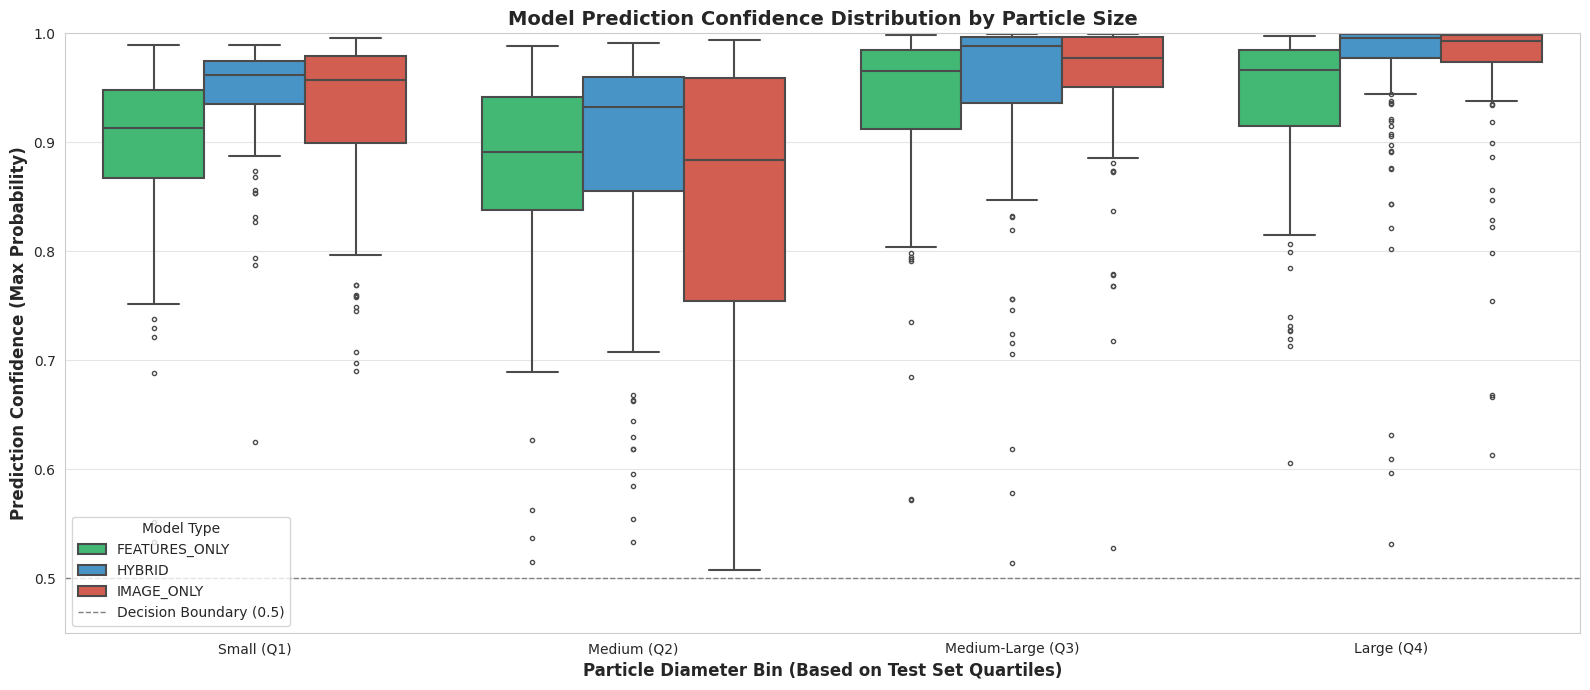

✓ Confidence boxplot by size saved to confidence_boxplot_by_size.png


In [ ]:
plot_confidence_by_size(ablation_results,model_types=MODEL_TYPES, test_diameters=test_diameters)

In [ ]:
def compute_comprehensive_metrics(y_true, y_pred, y_pred_probs, class_names=['Liquid', 'Solid']):
    """
    Compute all metrics recommended for imbalanced classification.

    Goes beyond accuracy to provide complete picture of model performance.

    Parameters:
    -----------
    y_true : array
        True labels (integers)
    y_pred : array
        Predicted labels (integers)
    y_pred_probs : array
        Prediction probabilities
    class_names : list
        Names of classes

    Returns:
    --------
    dict of metrics
    """
    metrics = {}

    # Overall metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)

    # Macro-averaged metrics (equal weight to each class - RECOMMENDED for imbalanced data)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Weighted-averaged metrics (weight by class frequency)
    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Per-class metrics
    per_class = classification_report(y_true, y_pred, target_names=class_names,
                                     output_dict=True, zero_division=0)
    for i, class_name in enumerate(class_names):
        metrics[f'{class_name}_precision'] = per_class[class_name]['precision']
        metrics[f'{class_name}_recall'] = per_class[class_name]['recall']
        metrics[f'{class_name}_f1'] = per_class[class_name]['f1-score']
        metrics[f'{class_name}_support'] = per_class[class_name]['support']

    # Confusion matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics


print("✓ Comprehensive metrics function defined")

✓ Comprehensive metrics function defined


## 19. Save Results

In [ ]:
# Save summary to CSV
summary_df.to_csv('ablation_summary.csv', index=False)
print("✓ Summary saved to ablation_summary.csv")

# Save detailed results to pickle
with open('ablation_results_detailed.pkl', 'wb') as f:
    pickle.dump(ablation_results, f)
print("✓ Detailed results saved to ablation_results_detailed.pkl")

✓ Summary saved to ablation_summary.csv
✓ Detailed results saved to ablation_results_detailed.pkl
